In [1]:
import os
import numpy as np
from tqdm import tqdm
import shutil
import cv2
import random
import sys
sys.path.append(".")
# random.seed(10)
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
# YOLOv8
from ultralytics.yolo.engine.model import YOLO
from ultralytics.yolo.cfg import cfg2dict, get_cfg
from ultralytics.yolo.data.build import build_dataloader
from ultralytics.yolo.v8.detect.train import DetectionTrainer
# from utils.tools import (boxes_to_coor, compute_normalized_cross_correlation,
#                          cut_images, delete_min_object_iter, delete_temp_img,
#                          save_loss, save_visualize_image)

# UNET
from networks.unet import Unet



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [3]:
from ultralytics.yolo.utils.instance import  Instances 

def cut_images(shape, new_shape = [640,640]):
    x,y,w,h = 0.5,0.5,1,1
    gt = Instances(np.array([x, y, w, h]),bbox_format= 'xywh')
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    #r = min(r, 1.0)
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    dw /= 2  # divide padding into 2 sides
    dh /= 2
    ratio = r, r  # width, height ratios
    gt.convert_bbox(format='xyxy')
    gt.denormalize(*shape[:2][::-1])
    gt.scale(*ratio)
    gt.add_padding(dw, dh)
    bbox_after = gt._bboxes.bboxes.reshape(-1).astype(int)
    return bbox_after

In [4]:
def get_targets(img, detector):
    results = detector(img)[0].boxes

    return results.xywhn.cpu(), results.cls1.cpu(), torch.ones_like(results.cls2, dtype=torch.float) * 14

In [5]:
def get_adv_labels(labels, n_classes=80):
    """Assign adversarial labels to a set of correct labels,
        i.e. randomly sample from incorrect classes.
    """
    adv_labels = torch.zeros_like(labels)
    for i in range(len(labels)):
        # FIXME Include or exclude background class?
        incorrect_labels = [l for l in range(n_classes) if l != labels[i]]
        adv_labels[i] = random.choice(incorrect_labels)

    return adv_labels

In [6]:
def reduce_sum(x, keepdim=True):
	for a in reversed(range(1, x.dim())):
		x = x.sum(a, keepdim=keepdim)

	return x


def L2_dist(x, y):
	return reduce_sum((x - y)**2)

# Train

In [7]:
yaml_path = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/ultralytics/yolo/cfg/my_config.yaml'
img_path = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/images/val'
data_info_path = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/ultralytics/datasets/coco2017.yaml'
yaml_path = './ultralytics/yolo/cfg/my_config.yaml'

In [8]:
# t_img_path = "/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/images/val/000000298251.jpg"
# img = cv2.imread(t_img_path)

# detector = YOLO("yolov8n.pt")
# detector.conf = 0.25
# detector.model.cuda()
# detector.model.eval()

# print(detector.model.training)
# results = detector.predict(img)[0].boxes
# results

In [9]:
lr = 0.005
decay_step = 500
decay_gamma = 0.5
iterations=[0,10,50,100,700,1100,1500]
generator = Unet (
                in_chans = 3,  #Number of channels in the input to the U-Net model
                out_chans = 3, #Number of channels in the output to the U-Net model
                chans = 64,    #Number of output channels of the first convolution layer
            ).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(generator.parameters(), lr=lr, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=decay_step, gamma=decay_gamma)

detector = YOLO("yolov8n.pt")
detector.conf = 0.25
detector.model.cuda()
detector.model.eval()
print("Is detector in training mode:", detector.model.training)

print("############################# TRAINER #############################")
trainer = DetectionTrainer(yaml_path)
trainer.setup_model()
trainer.set_model_attributes()
# trainer.model.train()
trainer.model.cuda()
trainer.model.eval()
print("Is trainer in training mode:", detector.model.training)
m = trainer.model.model[-1]
nc = m.nc
no = m.no
reg_max = m.reg_max

Ultralytics YOLOv8.0.83 🚀 Python-3.10.13 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
yolo/engine/trainer: task=detect, mode=predict, model=yolov8n.pt, data=ultralytics/datasets/coco2017.yaml, epochs=1, patience=10, batch=1, imgsz=640, save=True, save_period=100, cache=False, device=0, workers=8, project=None, name=None, augment=False, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, YOLO_VERBOSE=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.25, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=True, save_conf=False, save_crop=False, hide_labels=True, hide_conf=True, vid_stride=1, line_thickness=3, visualize=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

Is detector in training mode: False
############################# TRAINER #############################
######################################################### Son added #########################################################


Model summary: 225 layers, 3157200 parameters, 3157200 gradients, 8.9 GFLOPs

Transferred 355/355 items from pretrained weights


Is trainer in training mode: False


In [10]:
def compare_models(model_1, model_2):
    models_differ = 0
    for key_item_1, key_item_2 in zip(model_1.state_dict().items(), model_2.state_dict().items()):
        if torch.equal(key_item_1[1], key_item_2[1]):
            pass
        else:
            models_differ += 1
            if (key_item_1[0] == key_item_2[0]):
                print('Mismtach found at', key_item_1[0])
            else:
                raise Exception
    if models_differ == 0:
        print('Models match perfectly! :)')

In [11]:
compare_models(detector.model, trainer.model)

Models match perfectly! :)


In [12]:
def xywh2xyxy(x):
    """
    Convert bounding box coordinates from (x, y, width, height) format to (x1, y1, x2, y2) format where (x1, y1) is the
    top-left corner and (x2, y2) is the bottom-right corner.

    Args:
        x (np.ndarray) or (torch.Tensor): The input bounding box coordinates in (x, y, width, height) format.
    Returns:
        y (np.ndarray) or (torch.Tensor): The bounding box coordinates in (x1, y1, x2, y2) format.
    """
    y = x.clone() if isinstance(x, torch.Tensor) else np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
    y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
    y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
    y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
    return y

In [13]:
import time
import torchvision
from ultralytics.yolo.utils.metrics import box_iou

def non_max_suppression(
        prediction,
        conf_thres=0.25,
        iou_thres=0.45,
        classes=None,
        agnostic=False,
        multi_label=False,
        labels=(),
        max_det=300,
        nc=0,  # number of classes (optional)
        max_time_img=0.05,
        max_nms=30000,
        max_wh=7680,
):
    # Checks
    assert 0 <= conf_thres <= 1, f'Invalid Confidence threshold {conf_thres}, valid values are between 0.0 and 1.0'
    assert 0 <= iou_thres <= 1, f'Invalid IoU {iou_thres}, valid values are between 0.0 and 1.0'
    if isinstance(prediction, (list, tuple)):  # YOLOv8 model in validation model, output = (inference_out, loss_out)
        prediction = prediction[0]  # select only inference output

    device = prediction.device
    mps = 'mps' in device.type  # Apple MPS
    if mps:  # MPS not fully supported yet, convert tensors to CPU before NMS
        prediction = prediction.cpu()
    bs = prediction.shape[0]  # batch size
    nc = nc or (prediction.shape[1] - 4)  # number of classes
    nm = prediction.shape[1] - nc - 4
    mi = 4 + nc  # mask start index
    xc = prediction[:, 4:mi].amax(1) > conf_thres  # candidates

    # Settings
    # min_wh = 2  # (pixels) minimum box width and height
    time_limit = 0.5 + max_time_img * bs  # seconds to quit after
    redundant = True  # require redundant detections
    multi_label &= nc > 1  # multiple labels per box (adds 0.5ms/img)
    merge = False  # use merge-NMS

    t = time.time()
    output = [torch.zeros((0, 6 + nm), device=prediction.device)] * bs
    for xi, x in enumerate(prediction):  # image index, image inference
        x = x.transpose(0, -1)[xc[xi]]  # confidence
    
        # Cat apriori labels if autolabelling
        if labels and len(labels[xi]):
            lb = labels[xi]
            v = torch.zeros((len(lb), nc + nm + 5), device=x.device)
            v[:, :4] = lb[:, 1:5]  # box
            v[range(len(lb)), lb[:, 0].long() + 4] = 1.0  # cls
            x = torch.cat((x, v), 0)

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Detections matrix nx6 (xyxy, conf, cls)
        box, cls, mask = x.split((4, nc, nm), 1)
        box = xywh2xyxy(box)  # center_x, center_y, width, height) to (x1, y1, x2, y2)

        if multi_label:
            i, j = (cls > conf_thres).nonzero(as_tuple=False).T
            x = torch.cat((box[i], x[i, 4 + j, None], j[:, None].float(), mask[i]), 1)
        else:  # best class only
            conf, j = cls.max(1, keepdim=True)
            x = torch.cat((box, conf, j.float(), cls), 1)[conf.view(-1) > conf_thres]
        # else:  # 2 best class
        #     conf, j = cls.topk(2, 1)
        #     x = torch.cat((box, conf[:, 0].unsqueeze(1), j[:, 0].unsqueeze(1).float(), conf[:, 1].unsqueeze(1), j[:, 1].unsqueeze(1).float()), 1)[conf[:, 0].view(-1) > conf_thres]

        # Filter by class
        if classes is not None:
            x = x[(x[:, 5:6] == torch.tensor(classes, device=x.device)).any(1)]

        # Check shape
        n = x.shape[0]  # number of boxes
        if not n:  # no boxes
            continue
        x = x[x[:, 4].argsort(descending=True)[:max_nms]]  # sort by confidence and remove excess boxes

        # Batched NMS
        c = x[:, 5:6] * (0 if agnostic else max_wh)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        i = i[:max_det]  # limit detections
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            # Update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
            iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix
            weights = iou * scores[None]  # box weights
            x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            if redundant:
                i = i[iou.sum(1) > 1]  # require redundancy
        output[xi] = x[i]
        
    return output

train: Scanning /home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/labels/val.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]

[0/5000] Attacking image 000000298251.jpg ...


  0%|          | 2/500 [00:02<08:41,  1.05s/it]

[INFO] Loss misclassify: 351.48370361328125 | Loss pertub: tensor([[[[448.5149]]]], device='cuda:0') | Total loss: 351.48370361328125
[INFO] Loss misclassify: 351.439453125 | Loss pertub: tensor([[[[1813.8134]]]], device='cuda:0') | Total loss: 351.439453125


  1%|          | 4/500 [00:02<03:48,  2.17it/s]

[INFO] Loss misclassify: 307.5186462402344 | Loss pertub: tensor([[[[3608.7156]]]], device='cuda:0') | Total loss: 307.5186462402344
[INFO] Loss misclassify: 395.3553771972656 | Loss pertub: tensor([[[[3825.0769]]]], device='cuda:0') | Total loss: 395.3553771972656


  1%|          | 6/500 [00:03<02:24,  3.41it/s]

[INFO] Loss misclassify: 263.62103271484375 | Loss pertub: tensor([[[[4859.3672]]]], device='cuda:0') | Total loss: 263.62103271484375
[INFO] Loss misclassify: 263.56005859375 | Loss pertub: tensor([[[[5708.4111]]]], device='cuda:0') | Total loss: 263.56005859375


  2%|▏         | 8/500 [00:03<01:52,  4.36it/s]

[INFO] Loss misclassify: 219.718994140625 | Loss pertub: tensor([[[[6020.9492]]]], device='cuda:0') | Total loss: 219.718994140625
[INFO] Loss misclassify: 263.5232238769531 | Loss pertub: tensor([[[[6254.6362]]]], device='cuda:0') | Total loss: 263.5232238769531


  2%|▏         | 10/500 [00:03<01:36,  5.08it/s]

[INFO] Loss misclassify: 175.79666137695312 | Loss pertub: tensor([[[[7528.8174]]]], device='cuda:0') | Total loss: 175.79666137695312
[INFO] Loss misclassify: 175.77964782714844 | Loss pertub: tensor([[[[8383.7637]]]], device='cuda:0') | Total loss: 175.77964782714844


  2%|▏         | 12/500 [00:04<01:29,  5.48it/s]

[INFO] Loss misclassify: 175.777587890625 | Loss pertub: tensor([[[[9082.5889]]]], device='cuda:0') | Total loss: 175.777587890625
[INFO] Loss misclassify: 175.79562377929688 | Loss pertub: tensor([[[[9865.3242]]]], device='cuda:0') | Total loss: 175.79562377929688


  3%|▎         | 14/500 [00:04<01:25,  5.71it/s]

[INFO] Loss misclassify: 175.78692626953125 | Loss pertub: tensor([[[[10774.1963]]]], device='cuda:0') | Total loss: 175.78692626953125
[INFO] Loss misclassify: 131.8850860595703 | Loss pertub: tensor([[[[11672.3877]]]], device='cuda:0') | Total loss: 131.8850860595703


  3%|▎         | 16/500 [00:04<01:23,  5.78it/s]

[INFO] Loss misclassify: 131.87429809570312 | Loss pertub: tensor([[[[12292.8721]]]], device='cuda:0') | Total loss: 131.87429809570312
[INFO] Loss misclassify: 175.75820922851562 | Loss pertub: tensor([[[[12680.9111]]]], device='cuda:0') | Total loss: 175.75820922851562


  4%|▎         | 18/500 [00:05<01:21,  5.90it/s]

[INFO] Loss misclassify: 131.864013671875 | Loss pertub: tensor([[[[13590.0986]]]], device='cuda:0') | Total loss: 131.864013671875
[INFO] Loss misclassify: 87.98316955566406 | Loss pertub: tensor([[[[14592.7588]]]], device='cuda:0') | Total loss: 87.98316955566406


  4%|▍         | 20/500 [00:05<01:23,  5.74it/s]

[INFO] Loss misclassify: 131.81988525390625 | Loss pertub: tensor([[[[15601.5898]]]], device='cuda:0') | Total loss: 131.81988525390625
[INFO] Loss misclassify: 87.97895812988281 | Loss pertub: tensor([[[[16472.1738]]]], device='cuda:0') | Total loss: 87.97895812988281


  4%|▍         | 22/500 [00:05<01:23,  5.73it/s]

[INFO] Loss misclassify: 131.84201049804688 | Loss pertub: tensor([[[[17240.5605]]]], device='cuda:0') | Total loss: 131.84201049804688
[INFO] Loss misclassify: 175.7257843017578 | Loss pertub: tensor([[[[17932.6172]]]], device='cuda:0') | Total loss: 175.7257843017578


  5%|▍         | 24/500 [00:06<01:21,  5.86it/s]

[INFO] Loss misclassify: 131.8375701904297 | Loss pertub: tensor([[[[18574.9629]]]], device='cuda:0') | Total loss: 131.8375701904297
[INFO] Loss misclassify: 131.83108520507812 | Loss pertub: tensor([[[[19164.4531]]]], device='cuda:0') | Total loss: 131.83108520507812


  5%|▌         | 26/500 [00:06<01:19,  5.95it/s]

[INFO] Loss misclassify: 87.96392822265625 | Loss pertub: tensor([[[[19642.4277]]]], device='cuda:0') | Total loss: 87.96392822265625
[INFO] Loss misclassify: 87.95757293701172 | Loss pertub: tensor([[[[20211.5918]]]], device='cuda:0') | Total loss: 87.95757293701172


  6%|▌         | 28/500 [00:06<01:19,  5.94it/s]

[INFO] Loss misclassify: 131.8137969970703 | Loss pertub: tensor([[[[20688.8711]]]], device='cuda:0') | Total loss: 131.8137969970703
[INFO] Loss misclassify: 219.57064819335938 | Loss pertub: tensor([[[[21132.7754]]]], device='cuda:0') | Total loss: 219.57064819335938


  6%|▌         | 30/500 [00:07<01:18,  5.98it/s]

[INFO] Loss misclassify: 219.56549072265625 | Loss pertub: tensor([[[[21665.1152]]]], device='cuda:0') | Total loss: 219.56549072265625
[INFO] Loss misclassify: 87.98343658447266 | Loss pertub: tensor([[[[22209.6562]]]], device='cuda:0') | Total loss: 87.98343658447266


  6%|▋         | 32/500 [00:07<01:20,  5.84it/s]

[INFO] Loss misclassify: 87.98446655273438 | Loss pertub: tensor([[[[22736.6953]]]], device='cuda:0') | Total loss: 87.98446655273438
[INFO] Loss misclassify: 87.97942352294922 | Loss pertub: tensor([[[[23265.4473]]]], device='cuda:0') | Total loss: 87.97942352294922


  7%|▋         | 34/500 [00:07<01:19,  5.87it/s]

[INFO] Loss misclassify: 131.8441619873047 | Loss pertub: tensor([[[[23800.4219]]]], device='cuda:0') | Total loss: 131.8441619873047
[INFO] Loss misclassify: 175.733154296875 | Loss pertub: tensor([[[[24171.6699]]]], device='cuda:0') | Total loss: 175.733154296875


  7%|▋         | 36/500 [00:08<01:18,  5.90it/s]

[INFO] Loss misclassify: 87.9664535522461 | Loss pertub: tensor([[[[25007.7012]]]], device='cuda:0') | Total loss: 87.9664535522461
[INFO] Loss misclassify: 87.96234130859375 | Loss pertub: tensor([[[[25816.5996]]]], device='cuda:0') | Total loss: 87.96234130859375


  8%|▊         | 38/500 [00:08<01:18,  5.88it/s]

[INFO] Loss misclassify: 87.95805358886719 | Loss pertub: tensor([[[[26581.5723]]]], device='cuda:0') | Total loss: 87.95805358886719
[INFO] Loss misclassify: 87.94436645507812 | Loss pertub: tensor([[[[27271.3613]]]], device='cuda:0') | Total loss: 87.94436645507812


  8%|▊         | 40/500 [00:08<01:17,  5.94it/s]

[INFO] Loss misclassify: 87.94915771484375 | Loss pertub: tensor([[[[27895.1914]]]], device='cuda:0') | Total loss: 87.94915771484375
[INFO] Loss misclassify: 87.94464111328125 | Loss pertub: tensor([[[[28413.8164]]]], device='cuda:0') | Total loss: 87.94464111328125


  8%|▊         | 42/500 [00:09<01:16,  5.95it/s]

[INFO] Loss misclassify: 87.94152069091797 | Loss pertub: tensor([[[[28833.1074]]]], device='cuda:0') | Total loss: 87.94152069091797
[INFO] Loss misclassify: 87.93991088867188 | Loss pertub: tensor([[[[29146.1387]]]], device='cuda:0') | Total loss: 87.93991088867188


  9%|▉         | 44/500 [00:09<01:16,  5.97it/s]

[INFO] Loss misclassify: 131.79974365234375 | Loss pertub: tensor([[[[29435.8066]]]], device='cuda:0') | Total loss: 131.79974365234375
[INFO] Loss misclassify: 87.93275451660156 | Loss pertub: tensor([[[[29725.1074]]]], device='cuda:0') | Total loss: 87.93275451660156


  9%|▉         | 46/500 [00:09<01:16,  5.95it/s]

[INFO] Loss misclassify: 87.94226837158203 | Loss pertub: tensor([[[[30023.3887]]]], device='cuda:0') | Total loss: 87.94226837158203
[INFO] Loss misclassify: 87.93342590332031 | Loss pertub: tensor([[[[30763.3535]]]], device='cuda:0') | Total loss: 87.93342590332031


 10%|▉         | 48/500 [00:10<01:15,  5.97it/s]

[INFO] Loss misclassify: 131.79962158203125 | Loss pertub: tensor([[[[31581.1348]]]], device='cuda:0') | Total loss: 131.79962158203125
[INFO] Loss misclassify: 87.91352844238281 | Loss pertub: tensor([[[[32162.3301]]]], device='cuda:0') | Total loss: 87.91352844238281


 10%|█         | 50/500 [00:10<01:15,  5.93it/s]

[INFO] Loss misclassify: 87.93400573730469 | Loss pertub: tensor([[[[32726.0039]]]], device='cuda:0') | Total loss: 87.93400573730469
[INFO] Loss misclassify: 219.5580291748047 | Loss pertub: tensor([[[[33712.8633]]]], device='cuda:0') | Total loss: 219.5580291748047


 10%|█         | 52/500 [00:10<01:15,  5.91it/s]

[INFO] Loss misclassify: 87.93199157714844 | Loss pertub: tensor([[[[33756.2266]]]], device='cuda:0') | Total loss: 87.93199157714844
[INFO] Loss misclassify: 87.91645812988281 | Loss pertub: tensor([[[[34516.5508]]]], device='cuda:0') | Total loss: 87.91645812988281


 11%|█         | 54/500 [00:11<01:16,  5.86it/s]

[INFO] Loss misclassify: 131.77969360351562 | Loss pertub: tensor([[[[35893.0156]]]], device='cuda:0') | Total loss: 131.77969360351562
[INFO] Loss misclassify: 219.49105834960938 | Loss pertub: tensor([[[[37075.7578]]]], device='cuda:0') | Total loss: 219.49105834960938


 11%|█         | 56/500 [00:11<01:14,  5.92it/s]

[INFO] Loss misclassify: 87.90340423583984 | Loss pertub: tensor([[[[37649.0977]]]], device='cuda:0') | Total loss: 87.90340423583984
[INFO] Loss misclassify: 87.83958435058594 | Loss pertub: tensor([[[[38695.7031]]]], device='cuda:0') | Total loss: 87.83958435058594


 12%|█▏        | 58/500 [00:11<01:15,  5.88it/s]

[INFO] Loss misclassify: 87.86540222167969 | Loss pertub: tensor([[[[40327.5938]]]], device='cuda:0') | Total loss: 87.86540222167969
[INFO] Loss misclassify: 175.6329345703125 | Loss pertub: tensor([[[[41155.0156]]]], device='cuda:0') | Total loss: 175.6329345703125


 12%|█▏        | 60/500 [00:12<01:15,  5.86it/s]

[INFO] Loss misclassify: 131.78329467773438 | Loss pertub: tensor([[[[41821.2500]]]], device='cuda:0') | Total loss: 131.78329467773438
[INFO] Loss misclassify: 131.72528076171875 | Loss pertub: tensor([[[[44039.6094]]]], device='cuda:0') | Total loss: 131.72528076171875


 12%|█▏        | 62/500 [00:12<01:15,  5.81it/s]

[INFO] Loss misclassify: 87.88400268554688 | Loss pertub: tensor([[[[46768.1406]]]], device='cuda:0') | Total loss: 87.88400268554688
[INFO] Loss misclassify: 87.86316680908203 | Loss pertub: tensor([[[[47266.4258]]]], device='cuda:0') | Total loss: 87.86316680908203


 13%|█▎        | 64/500 [00:12<01:14,  5.85it/s]

[INFO] Loss misclassify: 131.643310546875 | Loss pertub: tensor([[[[48304.8281]]]], device='cuda:0') | Total loss: 131.643310546875
[INFO] Loss misclassify: 131.7585906982422 | Loss pertub: tensor([[[[49200.8945]]]], device='cuda:0') | Total loss: 131.7585906982422


 13%|█▎        | 66/500 [00:13<01:13,  5.92it/s]

[INFO] Loss misclassify: 131.79327392578125 | Loss pertub: tensor([[[[49366.2305]]]], device='cuda:0') | Total loss: 131.79327392578125
[INFO] Loss misclassify: 87.83792114257812 | Loss pertub: tensor([[[[51765.7227]]]], device='cuda:0') | Total loss: 87.83792114257812


 14%|█▎        | 68/500 [00:13<01:12,  5.97it/s]

[INFO] Loss misclassify: 87.840576171875 | Loss pertub: tensor([[[[54565.3242]]]], device='cuda:0') | Total loss: 87.840576171875
[INFO] Loss misclassify: 87.8469009399414 | Loss pertub: tensor([[[[56485.1875]]]], device='cuda:0') | Total loss: 87.8469009399414


 14%|█▍        | 70/500 [00:14<01:12,  5.91it/s]

[INFO] Loss misclassify: 87.82027435302734 | Loss pertub: tensor([[[[56574.7695]]]], device='cuda:0') | Total loss: 87.82027435302734
[INFO] Loss misclassify: 263.34967041015625 | Loss pertub: tensor([[[[56717.5742]]]], device='cuda:0') | Total loss: 263.34967041015625


 14%|█▍        | 72/500 [00:14<01:13,  5.85it/s]

[INFO] Loss misclassify: 175.5200958251953 | Loss pertub: tensor([[[[58526.7383]]]], device='cuda:0') | Total loss: 175.5200958251953
[INFO] Loss misclassify: 263.3248596191406 | Loss pertub: tensor([[[[57424.7656]]]], device='cuda:0') | Total loss: 263.3248596191406


 15%|█▍        | 74/500 [00:14<01:12,  5.92it/s]

[INFO] Loss misclassify: 131.67562866210938 | Loss pertub: tensor([[[[60070.1289]]]], device='cuda:0') | Total loss: 131.67562866210938
[INFO] Loss misclassify: 131.72434997558594 | Loss pertub: tensor([[[[63382.6875]]]], device='cuda:0') | Total loss: 131.72434997558594


 15%|█▌        | 76/500 [00:15<01:11,  5.97it/s]

[INFO] Loss misclassify: 131.70904541015625 | Loss pertub: tensor([[[[65655.6016]]]], device='cuda:0') | Total loss: 131.70904541015625
[INFO] Loss misclassify: 43.933319091796875 | Loss pertub: tensor([[[[66794.6875]]]], device='cuda:0') | Total loss: 43.933319091796875


 16%|█▌        | 78/500 [00:15<01:12,  5.84it/s]

[INFO] Loss misclassify: 131.67176818847656 | Loss pertub: tensor([[[[67551.1719]]]], device='cuda:0') | Total loss: 131.67176818847656
[INFO] Loss misclassify: 131.6953125 | Loss pertub: tensor([[[[70908.0781]]]], device='cuda:0') | Total loss: 131.6953125


 16%|█▌        | 80/500 [00:15<01:11,  5.88it/s]

[INFO] Loss misclassify: 131.61886596679688 | Loss pertub: tensor([[[[74486.1562]]]], device='cuda:0') | Total loss: 131.61886596679688
[INFO] Loss misclassify: 43.909080505371094 | Loss pertub: tensor([[[[78220.8203]]]], device='cuda:0') | Total loss: 43.909080505371094


 16%|█▋        | 82/500 [00:16<01:10,  5.90it/s]

[INFO] Loss misclassify: 87.76782989501953 | Loss pertub: tensor([[[[81257.4062]]]], device='cuda:0') | Total loss: 87.76782989501953
[INFO] Loss misclassify: 87.74593353271484 | Loss pertub: tensor([[[[83198.8594]]]], device='cuda:0') | Total loss: 87.74593353271484


 17%|█▋        | 84/500 [00:16<01:11,  5.82it/s]

[INFO] Loss misclassify: 175.3392791748047 | Loss pertub: tensor([[[[84274.6406]]]], device='cuda:0') | Total loss: 175.3392791748047
[INFO] Loss misclassify: 131.62619018554688 | Loss pertub: tensor([[[[83617.3594]]]], device='cuda:0') | Total loss: 131.62619018554688


 17%|█▋        | 86/500 [00:16<01:10,  5.87it/s]

[INFO] Loss misclassify: 219.4700927734375 | Loss pertub: tensor([[[[84642.2188]]]], device='cuda:0') | Total loss: 219.4700927734375
[INFO] Loss misclassify: 131.65902709960938 | Loss pertub: tensor([[[[86826.8984]]]], device='cuda:0') | Total loss: 131.65902709960938


 18%|█▊        | 88/500 [00:17<01:09,  5.94it/s]

[INFO] Loss misclassify: 43.9009895324707 | Loss pertub: tensor([[[[89195.4688]]]], device='cuda:0') | Total loss: 43.9009895324707
[INFO] Loss misclassify: 131.665283203125 | Loss pertub: tensor([[[[91715.5469]]]], device='cuda:0') | Total loss: 131.665283203125


 18%|█▊        | 90/500 [00:17<01:08,  5.95it/s]

[INFO] Loss misclassify: 87.77349853515625 | Loss pertub: tensor([[[[94682.7188]]]], device='cuda:0') | Total loss: 87.77349853515625
[INFO] Loss misclassify: 43.883949279785156 | Loss pertub: tensor([[[[97945.1250]]]], device='cuda:0') | Total loss: 43.883949279785156


 18%|█▊        | 92/500 [00:17<01:08,  5.97it/s]

[INFO] Loss misclassify: 43.88549041748047 | Loss pertub: tensor([[[[100562.8594]]]], device='cuda:0') | Total loss: 43.88549041748047
[INFO] Loss misclassify: 87.71200561523438 | Loss pertub: tensor([[[[102716.6484]]]], device='cuda:0') | Total loss: 87.71200561523438


 19%|█▉        | 94/500 [00:18<01:07,  6.00it/s]

[INFO] Loss misclassify: 43.87313461303711 | Loss pertub: tensor([[[[104203.5078]]]], device='cuda:0') | Total loss: 43.87313461303711
[INFO] Loss misclassify: 87.59140014648438 | Loss pertub: tensor([[[[105647.7969]]]], device='cuda:0') | Total loss: 87.59140014648438


 19%|█▉        | 96/500 [00:18<01:08,  5.93it/s]

[INFO] Loss misclassify: 43.86325454711914 | Loss pertub: tensor([[[[106450.5000]]]], device='cuda:0') | Total loss: 43.86325454711914
[INFO] Loss misclassify: 87.74688720703125 | Loss pertub: tensor([[[[107321.1484]]]], device='cuda:0') | Total loss: 87.74688720703125


 20%|█▉        | 98/500 [00:18<01:07,  5.97it/s]

[INFO] Loss misclassify: 87.7352523803711 | Loss pertub: tensor([[[[108019.5391]]]], device='cuda:0') | Total loss: 87.7352523803711
[INFO] Loss misclassify: 43.87047576904297 | Loss pertub: tensor([[[[108605.4297]]]], device='cuda:0') | Total loss: 43.87047576904297


 20%|██        | 100/500 [00:19<01:07,  5.88it/s]

[INFO] Loss misclassify: 43.88219451904297 | Loss pertub: tensor([[[[109044.6094]]]], device='cuda:0') | Total loss: 43.88219451904297
[INFO] Loss misclassify: 131.63323974609375 | Loss pertub: tensor([[[[109483.3594]]]], device='cuda:0') | Total loss: 131.63323974609375


 20%|██        | 102/500 [00:19<01:06,  5.96it/s]

[INFO] Loss misclassify: 131.6183624267578 | Loss pertub: tensor([[[[110511.0469]]]], device='cuda:0') | Total loss: 131.6183624267578
[INFO] Loss misclassify: 43.87859344482422 | Loss pertub: tensor([[[[112066.8984]]]], device='cuda:0') | Total loss: 43.87859344482422


 21%|██        | 103/500 [00:19<01:15,  5.23it/s]


[INFO] Loss misclassify: 43.86159896850586 | Loss pertub: tensor([[[[113483.9609]]]], device='cuda:0') | Total loss: 43.86159896850586
No more detected object!
[1/5000] Attacking image 000000205333.jpg ...


  0%|          | 2/500 [00:00<02:38,  3.15it/s]

[INFO] Loss misclassify: 131.81199645996094 | Loss pertub: tensor([[[[147142.1406]]]], device='cuda:0') | Total loss: 131.81199645996094
[INFO] Loss misclassify: 131.79061889648438 | Loss pertub: tensor([[[[148444.4375]]]], device='cuda:0') | Total loss: 131.79061889648438


  1%|          | 4/500 [00:01<01:56,  4.25it/s]

[INFO] Loss misclassify: 131.7866668701172 | Loss pertub: tensor([[[[149445.]]]], device='cuda:0') | Total loss: 131.7866668701172
[INFO] Loss misclassify: 131.78016662597656 | Loss pertub: tensor([[[[150071.7656]]]], device='cuda:0') | Total loss: 131.78016662597656


  1%|          | 6/500 [00:01<01:44,  4.72it/s]

[INFO] Loss misclassify: 131.76889038085938 | Loss pertub: tensor([[[[150114.7188]]]], device='cuda:0') | Total loss: 131.76889038085938
[INFO] Loss misclassify: 131.76358032226562 | Loss pertub: tensor([[[[150883.3125]]]], device='cuda:0') | Total loss: 131.76358032226562


  2%|▏         | 8/500 [00:01<01:38,  5.01it/s]

[INFO] Loss misclassify: 87.89772033691406 | Loss pertub: tensor([[[[152446.8750]]]], device='cuda:0') | Total loss: 87.89772033691406
[INFO] Loss misclassify: 87.896484375 | Loss pertub: tensor([[[[153586.8750]]]], device='cuda:0') | Total loss: 87.896484375


  2%|▏         | 10/500 [00:02<01:35,  5.14it/s]

[INFO] Loss misclassify: 87.89199829101562 | Loss pertub: tensor([[[[154294.4688]]]], device='cuda:0') | Total loss: 87.89199829101562
[INFO] Loss misclassify: 87.8853530883789 | Loss pertub: tensor([[[[154647.5938]]]], device='cuda:0') | Total loss: 87.8853530883789


  2%|▏         | 12/500 [00:02<01:33,  5.23it/s]

[INFO] Loss misclassify: 87.8823013305664 | Loss pertub: tensor([[[[154763.2188]]]], device='cuda:0') | Total loss: 87.8823013305664
[INFO] Loss misclassify: 87.87925720214844 | Loss pertub: tensor([[[[154920.8594]]]], device='cuda:0') | Total loss: 87.87925720214844


  3%|▎         | 14/500 [00:02<01:32,  5.27it/s]

[INFO] Loss misclassify: 87.87779235839844 | Loss pertub: tensor([[[[155116.1250]]]], device='cuda:0') | Total loss: 87.87779235839844
[INFO] Loss misclassify: 87.87648010253906 | Loss pertub: tensor([[[[155321.2344]]]], device='cuda:0') | Total loss: 87.87648010253906


  3%|▎         | 16/500 [00:03<01:32,  5.25it/s]

[INFO] Loss misclassify: 87.87673950195312 | Loss pertub: tensor([[[[155557.2344]]]], device='cuda:0') | Total loss: 87.87673950195312
[INFO] Loss misclassify: 87.8756103515625 | Loss pertub: tensor([[[[156234.8594]]]], device='cuda:0') | Total loss: 87.8756103515625


  4%|▎         | 18/500 [00:03<01:32,  5.19it/s]

[INFO] Loss misclassify: 87.87371826171875 | Loss pertub: tensor([[[[157267.6094]]]], device='cuda:0') | Total loss: 87.87371826171875
[INFO] Loss misclassify: 87.87055969238281 | Loss pertub: tensor([[[[158341.7344]]]], device='cuda:0') | Total loss: 87.87055969238281


  4%|▍         | 20/500 [00:04<01:32,  5.16it/s]

[INFO] Loss misclassify: 87.86872863769531 | Loss pertub: tensor([[[[159416.2031]]]], device='cuda:0') | Total loss: 87.86872863769531
[INFO] Loss misclassify: 87.86354064941406 | Loss pertub: tensor([[[[160563.2500]]]], device='cuda:0') | Total loss: 87.86354064941406


  4%|▍         | 22/500 [00:04<01:31,  5.25it/s]

[INFO] Loss misclassify: 87.85961151123047 | Loss pertub: tensor([[[[161440.2500]]]], device='cuda:0') | Total loss: 87.85961151123047
[INFO] Loss misclassify: 87.85427856445312 | Loss pertub: tensor([[[[162670.]]]], device='cuda:0') | Total loss: 87.85427856445312


  5%|▍         | 24/500 [00:04<01:30,  5.24it/s]

[INFO] Loss misclassify: 131.73297119140625 | Loss pertub: tensor([[[[164368.4219]]]], device='cuda:0') | Total loss: 131.73297119140625
[INFO] Loss misclassify: 87.81770324707031 | Loss pertub: tensor([[[[167138.2969]]]], device='cuda:0') | Total loss: 87.81770324707031


  5%|▌         | 26/500 [00:05<01:31,  5.20it/s]

[INFO] Loss misclassify: 43.93144989013672 | Loss pertub: tensor([[[[169073.6562]]]], device='cuda:0') | Total loss: 43.93144989013672
[INFO] Loss misclassify: 43.926422119140625 | Loss pertub: tensor([[[[174336.9531]]]], device='cuda:0') | Total loss: 43.926422119140625


  6%|▌         | 28/500 [00:05<01:30,  5.23it/s]

[INFO] Loss misclassify: 87.80807495117188 | Loss pertub: tensor([[[[179735.4688]]]], device='cuda:0') | Total loss: 87.80807495117188
[INFO] Loss misclassify: 87.845947265625 | Loss pertub: tensor([[[[179601.4375]]]], device='cuda:0') | Total loss: 87.845947265625


  6%|▌         | 30/500 [00:06<01:29,  5.24it/s]

[INFO] Loss misclassify: 43.92745590209961 | Loss pertub: tensor([[[[179586.6719]]]], device='cuda:0') | Total loss: 43.92745590209961
[INFO] Loss misclassify: 43.932044982910156 | Loss pertub: tensor([[[[176732.5781]]]], device='cuda:0') | Total loss: 43.932044982910156


  6%|▋         | 32/500 [00:06<01:28,  5.28it/s]

[INFO] Loss misclassify: 87.77078247070312 | Loss pertub: tensor([[[[172423.2188]]]], device='cuda:0') | Total loss: 87.77078247070312
[INFO] Loss misclassify: 43.886497497558594 | Loss pertub: tensor([[[[185854.5312]]]], device='cuda:0') | Total loss: 43.886497497558594


  7%|▋         | 34/500 [00:06<01:27,  5.30it/s]

[INFO] Loss misclassify: 43.87120056152344 | Loss pertub: tensor([[[[188687.5781]]]], device='cuda:0') | Total loss: 43.87120056152344
[INFO] Loss misclassify: 43.86430740356445 | Loss pertub: tensor([[[[187845.9375]]]], device='cuda:0') | Total loss: 43.86430740356445


  7%|▋         | 34/500 [00:06<01:35,  4.89it/s]


No more detected object!
[2/5000] Attacking image 000000449661.jpg ...


  0%|          | 0/500 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 3.81 GiB total capacity; 2.46 GiB already allocated; 19.44 MiB free; 2.53 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

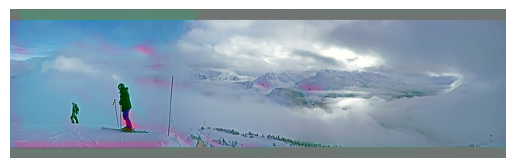

In [14]:
# from ultralytics.yolo.utils import DEFAULT_CFG, ROOT, ops
import torch.nn.functional as F

n_iter = 500     # số lần attack trên 1 ảnh

data_info = cfg2dict(data_info_path)
cfg = get_cfg(yaml_path)
#data loader
loader = build_dataloader(cfg= cfg, batch=1, img_path=img_path,data_info=data_info)

output_path = "./results"

for i, batch in enumerate(loader[0]):
    path_img        = loader[1].im_files[i]
    name_img        = os.path.split(path_img)[-1]

    print(f"[{i}/{len(loader[0])}] Attacking image {name_img} ...")

    batch_tensor    = torch.Tensor(batch['img'].float()).cuda()
    origin_tensor   = torch.Tensor(batch['img'].float()).cuda()
    img_before      = cv2.imread(path_img)
    x,y,_           = img_before.shape              # original img shape
    x_new,y_new     = batch_tensor.shape[-2:]       # shape img after augment with yolov8

    x1,y1,x2,y2     = cut_images((x,y,3),[x_new,y_new])
    
    # Acquire targets and corresponding labels to attack
    # target_boxes, target_labels, adv_labels = get_targets(img_before, detector)
    # print(adv_labels)

    # batch['cls'] = adv_labels
    # batch['bboxes'] = batch['bboxes'][:adv_labels.size()[0]]
    # batch['batch_idx'] = batch['batch_idx'][:adv_labels.size()[0]]

    batch_tensor.requires_grad_()
    batch_tensor.retain_grad()
    for j in tqdm(range(n_iter)):
        optimizer.zero_grad()
        perturbation = generator(batch_tensor)
        adv_inputs = torch.add(batch_tensor, perturbation)
        adv_inputs = torch.clamp(adv_inputs, 0, 255)
        
        b = trainer.model(adv_inputs / 255.)

        # Trả về Tensor gồm [8, 86]: 8 object detect được bên trong ảnh, mỗi object sẽ có: x, y, x, y, conf, cls, 80 conf score
        preds = non_max_suppression(b,
                                    cfg.conf,
                                    cfg.iou,
                                    agnostic=cfg.agnostic_nms,
                                    max_det=cfg.max_det,
                                    classes=cfg.classes)
        # print("preds:", preds[0], preds[0].size())
        pred_conf = preds[0][:, 6:]
        pred_cls = preds[0][:, 5].type(torch.LongTensor).to(device)

        adv_cls = get_adv_labels(pred_cls)
        if len(adv_cls) == 0:
            print("No more detected object!")
            plt.imshow(adv_inputs.squeeze().detach().cpu().permute(1, 2, 0)/255)
            plt.axis("off")
            plt.savefig(f'out_{name_img}',bbox_inches='tight', transparent="True", pad_inches=0)
            break
        # print("pred_cls:", pred_cls)
        # print("adv_cls:", adv_cls)
        real_loss = F.cross_entropy(pred_conf, pred_cls, reduction="sum")
        adv_loss = F.cross_entropy(pred_conf, adv_cls, reduction="sum")
        
        loss_misclassify = 10 * (adv_loss)
        # adv_loss.backward(retain_graph = True)
    
        loss_pertub = L2_dist(batch_tensor, adv_inputs) # check!
        total_loss = loss_misclassify
        total_loss.backward(retain_graph = True)

        optimizer.step()

        # total_losses.append(total_loss.data.cpu())
        
        # if (j + 1) % 101 == 0:
        print(f"[INFO] Loss misclassify: {loss_misclassify.data} | Loss pertub: {loss_pertub.data} | Total loss: {total_loss.data}")

        # print(loss_misclassify)


    plt.imshow(adv_inputs.squeeze().detach().cpu().permute(1, 2, 0)/255)

    if i == 10:
        break

In [15]:
torch.save(generator.state_dict(), "generator.pt")

train: Scanning /home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/labels/val.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]

[0/5000] Attacking image 000000298251.jpg ...


  0%|          | 2/500 [00:01<06:26,  1.29it/s]

[INFO] Loss misclassify: 196.77090454101562 | Loss pertub: tensor([[[[2325.1228]]]], device='cuda:0') | Total loss: 196.77090454101562
[INFO] Loss misclassify: 153.0100860595703 | Loss pertub: tensor([[[[17066.5742]]]], device='cuda:0') | Total loss: 153.0100860595703


  1%|          | 4/500 [00:02<02:59,  2.77it/s]

[INFO] Loss misclassify: 153.38131713867188 | Loss pertub: tensor([[[[22600.6660]]]], device='cuda:0') | Total loss: 153.38131713867188
[INFO] Loss misclassify: 173.34918212890625 | Loss pertub: tensor([[[[25419.8125]]]], device='cuda:0') | Total loss: 173.34918212890625


  1%|          | 6/500 [00:02<02:00,  4.10it/s]

[INFO] Loss misclassify: 150.96792602539062 | Loss pertub: tensor([[[[27051.7949]]]], device='cuda:0') | Total loss: 150.96792602539062
[INFO] Loss misclassify: 172.32144165039062 | Loss pertub: tensor([[[[28673.3574]]]], device='cuda:0') | Total loss: 172.32144165039062


  2%|▏         | 8/500 [00:02<01:37,  5.07it/s]

[INFO] Loss misclassify: 129.36009216308594 | Loss pertub: tensor([[[[32585.8340]]]], device='cuda:0') | Total loss: 129.36009216308594
[INFO] Loss misclassify: 171.3007354736328 | Loss pertub: tensor([[[[35363.1523]]]], device='cuda:0') | Total loss: 171.3007354736328


  2%|▏         | 10/500 [00:03<01:26,  5.66it/s]

[INFO] Loss misclassify: 128.78533935546875 | Loss pertub: tensor([[[[42173.1250]]]], device='cuda:0') | Total loss: 128.78533935546875
[INFO] Loss misclassify: 128.1414031982422 | Loss pertub: tensor([[[[46807.6875]]]], device='cuda:0') | Total loss: 128.1414031982422


  2%|▏         | 12/500 [00:03<01:21,  5.98it/s]

[INFO] Loss misclassify: 128.1932373046875 | Loss pertub: tensor([[[[51293.4492]]]], device='cuda:0') | Total loss: 128.1932373046875
[INFO] Loss misclassify: 149.70193481445312 | Loss pertub: tensor([[[[53144.4766]]]], device='cuda:0') | Total loss: 149.70193481445312


  3%|▎         | 14/500 [00:03<01:18,  6.17it/s]

[INFO] Loss misclassify: 127.28578186035156 | Loss pertub: tensor([[[[52086.9766]]]], device='cuda:0') | Total loss: 127.28578186035156
[INFO] Loss misclassify: 127.18122863769531 | Loss pertub: tensor([[[[54132.3438]]]], device='cuda:0') | Total loss: 127.18122863769531


  3%|▎         | 16/500 [00:04<01:17,  6.23it/s]

[INFO] Loss misclassify: 126.88689422607422 | Loss pertub: tensor([[[[60072.3398]]]], device='cuda:0') | Total loss: 126.88689422607422
[INFO] Loss misclassify: 167.54458618164062 | Loss pertub: tensor([[[[67417.1328]]]], device='cuda:0') | Total loss: 167.54458618164062


  4%|▎         | 18/500 [00:04<01:17,  6.25it/s]

[INFO] Loss misclassify: 123.85652160644531 | Loss pertub: tensor([[[[77014.4219]]]], device='cuda:0') | Total loss: 123.85652160644531
[INFO] Loss misclassify: 164.3922576904297 | Loss pertub: tensor([[[[85572.2734]]]], device='cuda:0') | Total loss: 164.3922576904297


  4%|▍         | 20/500 [00:04<01:16,  6.29it/s]

[INFO] Loss misclassify: 142.17185974121094 | Loss pertub: tensor([[[[93952.8281]]]], device='cuda:0') | Total loss: 142.17185974121094
[INFO] Loss misclassify: 140.99142456054688 | Loss pertub: tensor([[[[96745.1094]]]], device='cuda:0') | Total loss: 140.99142456054688


  4%|▍         | 22/500 [00:04<01:15,  6.30it/s]

[INFO] Loss misclassify: 139.25997924804688 | Loss pertub: tensor([[[[102619.1250]]]], device='cuda:0') | Total loss: 139.25997924804688
[INFO] Loss misclassify: 138.58018493652344 | Loss pertub: tensor([[[[106995.1797]]]], device='cuda:0') | Total loss: 138.58018493652344


  5%|▍         | 24/500 [00:05<01:15,  6.29it/s]

[INFO] Loss misclassify: 137.199951171875 | Loss pertub: tensor([[[[112742.2031]]]], device='cuda:0') | Total loss: 137.199951171875
[INFO] Loss misclassify: 157.26197814941406 | Loss pertub: tensor([[[[117901.5547]]]], device='cuda:0') | Total loss: 157.26197814941406


  5%|▌         | 26/500 [00:05<01:15,  6.31it/s]

[INFO] Loss misclassify: 157.39840698242188 | Loss pertub: tensor([[[[127428.2031]]]], device='cuda:0') | Total loss: 157.39840698242188
[INFO] Loss misclassify: 175.06729125976562 | Loss pertub: tensor([[[[142315.9062]]]], device='cuda:0') | Total loss: 175.06729125976562


  6%|▌         | 28/500 [00:05<01:14,  6.30it/s]

[INFO] Loss misclassify: 174.1980743408203 | Loss pertub: tensor([[[[151742.]]]], device='cuda:0') | Total loss: 174.1980743408203
[INFO] Loss misclassify: 173.68878173828125 | Loss pertub: tensor([[[[162262.7812]]]], device='cuda:0') | Total loss: 173.68878173828125


  6%|▌         | 30/500 [00:06<01:14,  6.33it/s]

[INFO] Loss misclassify: 172.82106018066406 | Loss pertub: tensor([[[[174038.7812]]]], device='cuda:0') | Total loss: 172.82106018066406
[INFO] Loss misclassify: 192.62191772460938 | Loss pertub: tensor([[[[181728.2344]]]], device='cuda:0') | Total loss: 192.62191772460938


  6%|▋         | 32/500 [00:06<01:14,  6.31it/s]

[INFO] Loss misclassify: 171.3486328125 | Loss pertub: tensor([[[[194550.7344]]]], device='cuda:0') | Total loss: 171.3486328125
[INFO] Loss misclassify: 171.07894897460938 | Loss pertub: tensor([[[[201781.9844]]]], device='cuda:0') | Total loss: 171.07894897460938


  7%|▋         | 34/500 [00:06<01:13,  6.32it/s]

[INFO] Loss misclassify: 169.92698669433594 | Loss pertub: tensor([[[[213034.8281]]]], device='cuda:0') | Total loss: 169.92698669433594
[INFO] Loss misclassify: 190.67710876464844 | Loss pertub: tensor([[[[218126.]]]], device='cuda:0') | Total loss: 190.67710876464844


  7%|▋         | 36/500 [00:07<01:13,  6.31it/s]

[INFO] Loss misclassify: 192.8919219970703 | Loss pertub: tensor([[[[240273.5781]]]], device='cuda:0') | Total loss: 192.8919219970703
[INFO] Loss misclassify: 193.78207397460938 | Loss pertub: tensor([[[[249217.0469]]]], device='cuda:0') | Total loss: 193.78207397460938


  8%|▊         | 38/500 [00:07<01:13,  6.32it/s]

[INFO] Loss misclassify: 192.78707885742188 | Loss pertub: tensor([[[[257273.0781]]]], device='cuda:0') | Total loss: 192.78707885742188
[INFO] Loss misclassify: 212.34596252441406 | Loss pertub: tensor([[[[263983.0938]]]], device='cuda:0') | Total loss: 212.34596252441406


  8%|▊         | 40/500 [00:07<01:12,  6.33it/s]

[INFO] Loss misclassify: 190.0104522705078 | Loss pertub: tensor([[[[270082.0938]]]], device='cuda:0') | Total loss: 190.0104522705078
[INFO] Loss misclassify: 209.5030975341797 | Loss pertub: tensor([[[[275806.3438]]]], device='cuda:0') | Total loss: 209.5030975341797


  8%|▊         | 42/500 [00:08<01:12,  6.32it/s]

[INFO] Loss misclassify: 209.53179931640625 | Loss pertub: tensor([[[[284908.0625]]]], device='cuda:0') | Total loss: 209.53179931640625
[INFO] Loss misclassify: 208.27310180664062 | Loss pertub: tensor([[[[296967.5000]]]], device='cuda:0') | Total loss: 208.27310180664062


  9%|▉         | 44/500 [00:08<01:12,  6.32it/s]

[INFO] Loss misclassify: 207.29986572265625 | Loss pertub: tensor([[[[308549.7188]]]], device='cuda:0') | Total loss: 207.29986572265625
[INFO] Loss misclassify: 224.80752563476562 | Loss pertub: tensor([[[[315708.4688]]]], device='cuda:0') | Total loss: 224.80752563476562


  9%|▉         | 46/500 [00:08<01:11,  6.32it/s]

[INFO] Loss misclassify: 205.96112060546875 | Loss pertub: tensor([[[[324396.]]]], device='cuda:0') | Total loss: 205.96112060546875
[INFO] Loss misclassify: 205.12066650390625 | Loss pertub: tensor([[[[338912.8125]]]], device='cuda:0') | Total loss: 205.12066650390625


 10%|▉         | 48/500 [00:09<01:11,  6.29it/s]

[INFO] Loss misclassify: 204.29962158203125 | Loss pertub: tensor([[[[357610.6875]]]], device='cuda:0') | Total loss: 204.29962158203125
[INFO] Loss misclassify: 204.03512573242188 | Loss pertub: tensor([[[[370624.5312]]]], device='cuda:0') | Total loss: 204.03512573242188


 10%|█         | 50/500 [00:09<01:11,  6.29it/s]

[INFO] Loss misclassify: 203.55429077148438 | Loss pertub: tensor([[[[379652.7188]]]], device='cuda:0') | Total loss: 203.55429077148438
[INFO] Loss misclassify: 202.4906005859375 | Loss pertub: tensor([[[[387032.8438]]]], device='cuda:0') | Total loss: 202.4906005859375


 10%|█         | 52/500 [00:09<01:11,  6.30it/s]

[INFO] Loss misclassify: 202.67913818359375 | Loss pertub: tensor([[[[393379.4062]]]], device='cuda:0') | Total loss: 202.67913818359375
[INFO] Loss misclassify: 201.57571411132812 | Loss pertub: tensor([[[[409076.9375]]]], device='cuda:0') | Total loss: 201.57571411132812


 11%|█         | 54/500 [00:10<01:10,  6.32it/s]

[INFO] Loss misclassify: 201.45147705078125 | Loss pertub: tensor([[[[420903.8438]]]], device='cuda:0') | Total loss: 201.45147705078125
[INFO] Loss misclassify: 201.0936737060547 | Loss pertub: tensor([[[[424290.9062]]]], device='cuda:0') | Total loss: 201.0936737060547


 11%|█         | 56/500 [00:10<01:10,  6.31it/s]

[INFO] Loss misclassify: 201.32325744628906 | Loss pertub: tensor([[[[427899.7188]]]], device='cuda:0') | Total loss: 201.32325744628906
[INFO] Loss misclassify: 200.5317840576172 | Loss pertub: tensor([[[[442957.2188]]]], device='cuda:0') | Total loss: 200.5317840576172


 12%|█▏        | 58/500 [00:10<01:10,  6.31it/s]

[INFO] Loss misclassify: 200.82974243164062 | Loss pertub: tensor([[[[456067.3125]]]], device='cuda:0') | Total loss: 200.82974243164062
[INFO] Loss misclassify: 200.02784729003906 | Loss pertub: tensor([[[[469576.8125]]]], device='cuda:0') | Total loss: 200.02784729003906


 12%|█▏        | 60/500 [00:10<01:09,  6.31it/s]

[INFO] Loss misclassify: 199.86383056640625 | Loss pertub: tensor([[[[478362.7188]]]], device='cuda:0') | Total loss: 199.86383056640625
[INFO] Loss misclassify: 199.7758331298828 | Loss pertub: tensor([[[[485752.8125]]]], device='cuda:0') | Total loss: 199.7758331298828


 12%|█▏        | 62/500 [00:11<01:09,  6.31it/s]

[INFO] Loss misclassify: 199.30154418945312 | Loss pertub: tensor([[[[496704.7188]]]], device='cuda:0') | Total loss: 199.30154418945312
[INFO] Loss misclassify: 199.22946166992188 | Loss pertub: tensor([[[[506764.7188]]]], device='cuda:0') | Total loss: 199.22946166992188


 13%|█▎        | 64/500 [00:11<01:09,  6.31it/s]

[INFO] Loss misclassify: 198.96151733398438 | Loss pertub: tensor([[[[515648.5938]]]], device='cuda:0') | Total loss: 198.96151733398438
[INFO] Loss misclassify: 198.8245849609375 | Loss pertub: tensor([[[[521633.3438]]]], device='cuda:0') | Total loss: 198.8245849609375


 13%|█▎        | 66/500 [00:11<01:09,  6.27it/s]

[INFO] Loss misclassify: 198.67999267578125 | Loss pertub: tensor([[[[528144.8125]]]], device='cuda:0') | Total loss: 198.67999267578125
[INFO] Loss misclassify: 198.4488525390625 | Loss pertub: tensor([[[[534257.2500]]]], device='cuda:0') | Total loss: 198.4488525390625


 14%|█▎        | 68/500 [00:12<01:08,  6.29it/s]

[INFO] Loss misclassify: 198.32008361816406 | Loss pertub: tensor([[[[537767.5625]]]], device='cuda:0') | Total loss: 198.32008361816406
[INFO] Loss misclassify: 198.1802978515625 | Loss pertub: tensor([[[[542070.6250]]]], device='cuda:0') | Total loss: 198.1802978515625


 14%|█▍        | 70/500 [00:12<01:08,  6.29it/s]

[INFO] Loss misclassify: 198.04098510742188 | Loss pertub: tensor([[[[549698.6875]]]], device='cuda:0') | Total loss: 198.04098510742188
[INFO] Loss misclassify: 197.90281677246094 | Loss pertub: tensor([[[[559163.]]]], device='cuda:0') | Total loss: 197.90281677246094


 14%|█▍        | 72/500 [00:12<01:07,  6.30it/s]

[INFO] Loss misclassify: 197.73446655273438 | Loss pertub: tensor([[[[567013.3125]]]], device='cuda:0') | Total loss: 197.73446655273438
[INFO] Loss misclassify: 197.60169982910156 | Loss pertub: tensor([[[[573405.9375]]]], device='cuda:0') | Total loss: 197.60169982910156


 15%|█▍        | 74/500 [00:13<01:07,  6.29it/s]

[INFO] Loss misclassify: 197.47702026367188 | Loss pertub: tensor([[[[580303.5625]]]], device='cuda:0') | Total loss: 197.47702026367188
[INFO] Loss misclassify: 197.3619842529297 | Loss pertub: tensor([[[[586059.2500]]]], device='cuda:0') | Total loss: 197.3619842529297


 15%|█▌        | 76/500 [00:13<01:07,  6.30it/s]

[INFO] Loss misclassify: 197.20455932617188 | Loss pertub: tensor([[[[591396.6875]]]], device='cuda:0') | Total loss: 197.20455932617188
[INFO] Loss misclassify: 197.0921173095703 | Loss pertub: tensor([[[[597181.7500]]]], device='cuda:0') | Total loss: 197.0921173095703


 16%|█▌        | 78/500 [00:13<01:06,  6.31it/s]

[INFO] Loss misclassify: 197.00802612304688 | Loss pertub: tensor([[[[604311.6250]]]], device='cuda:0') | Total loss: 197.00802612304688
[INFO] Loss misclassify: 196.87881469726562 | Loss pertub: tensor([[[[609958.6875]]]], device='cuda:0') | Total loss: 196.87881469726562


 16%|█▌        | 80/500 [00:14<01:06,  6.27it/s]

[INFO] Loss misclassify: 196.75967407226562 | Loss pertub: tensor([[[[615752.9375]]]], device='cuda:0') | Total loss: 196.75967407226562
[INFO] Loss misclassify: 196.6712646484375 | Loss pertub: tensor([[[[623138.5000]]]], device='cuda:0') | Total loss: 196.6712646484375


 16%|█▋        | 82/500 [00:14<01:06,  6.29it/s]

[INFO] Loss misclassify: 196.57302856445312 | Loss pertub: tensor([[[[627715.6875]]]], device='cuda:0') | Total loss: 196.57302856445312
[INFO] Loss misclassify: 196.47955322265625 | Loss pertub: tensor([[[[632234.1250]]]], device='cuda:0') | Total loss: 196.47955322265625


 17%|█▋        | 84/500 [00:14<01:06,  6.28it/s]

[INFO] Loss misclassify: 196.38851928710938 | Loss pertub: tensor([[[[635458.6875]]]], device='cuda:0') | Total loss: 196.38851928710938
[INFO] Loss misclassify: 196.30450439453125 | Loss pertub: tensor([[[[638104.]]]], device='cuda:0') | Total loss: 196.30450439453125


 17%|█▋        | 86/500 [00:15<01:05,  6.29it/s]

[INFO] Loss misclassify: 196.22703552246094 | Loss pertub: tensor([[[[641089.1250]]]], device='cuda:0') | Total loss: 196.22703552246094
[INFO] Loss misclassify: 196.14776611328125 | Loss pertub: tensor([[[[643344.6250]]]], device='cuda:0') | Total loss: 196.14776611328125


 18%|█▊        | 88/500 [00:15<01:05,  6.30it/s]

[INFO] Loss misclassify: 196.07351684570312 | Loss pertub: tensor([[[[646453.6875]]]], device='cuda:0') | Total loss: 196.07351684570312
[INFO] Loss misclassify: 195.99761962890625 | Loss pertub: tensor([[[[652490.5000]]]], device='cuda:0') | Total loss: 195.99761962890625


 18%|█▊        | 90/500 [00:15<01:05,  6.29it/s]

[INFO] Loss misclassify: 195.923095703125 | Loss pertub: tensor([[[[656439.]]]], device='cuda:0') | Total loss: 195.923095703125
[INFO] Loss misclassify: 195.85067749023438 | Loss pertub: tensor([[[[660807.1875]]]], device='cuda:0') | Total loss: 195.85067749023438


 18%|█▊        | 92/500 [00:16<01:04,  6.29it/s]

[INFO] Loss misclassify: 195.7748565673828 | Loss pertub: tensor([[[[667264.3125]]]], device='cuda:0') | Total loss: 195.7748565673828
[INFO] Loss misclassify: 195.7059326171875 | Loss pertub: tensor([[[[671960.3125]]]], device='cuda:0') | Total loss: 195.7059326171875


 19%|█▉        | 94/500 [00:16<01:04,  6.28it/s]

[INFO] Loss misclassify: 195.64430236816406 | Loss pertub: tensor([[[[678712.3125]]]], device='cuda:0') | Total loss: 195.64430236816406
[INFO] Loss misclassify: 195.57659912109375 | Loss pertub: tensor([[[[681899.4375]]]], device='cuda:0') | Total loss: 195.57659912109375


 19%|█▉        | 96/500 [00:16<01:04,  6.27it/s]

[INFO] Loss misclassify: 195.5107421875 | Loss pertub: tensor([[[[690938.8125]]]], device='cuda:0') | Total loss: 195.5107421875
[INFO] Loss misclassify: 216.07559204101562 | Loss pertub: tensor([[[[693689.1250]]]], device='cuda:0') | Total loss: 216.07559204101562


 20%|█▉        | 98/500 [00:17<01:03,  6.28it/s]

[INFO] Loss misclassify: 196.94825744628906 | Loss pertub: tensor([[[[692559.1250]]]], device='cuda:0') | Total loss: 196.94825744628906
[INFO] Loss misclassify: 216.45216369628906 | Loss pertub: tensor([[[[680357.5000]]]], device='cuda:0') | Total loss: 216.45216369628906


 20%|██        | 100/500 [00:17<01:03,  6.27it/s]

[INFO] Loss misclassify: 215.44981384277344 | Loss pertub: tensor([[[[678408.]]]], device='cuda:0') | Total loss: 215.44981384277344
[INFO] Loss misclassify: 220.81655883789062 | Loss pertub: tensor([[[[673550.9375]]]], device='cuda:0') | Total loss: 220.81655883789062


 20%|██        | 102/500 [00:17<01:03,  6.28it/s]

[INFO] Loss misclassify: 203.11285400390625 | Loss pertub: tensor([[[[727518.5625]]]], device='cuda:0') | Total loss: 203.11285400390625
[INFO] Loss misclassify: 208.38839721679688 | Loss pertub: tensor([[[[711711.1875]]]], device='cuda:0') | Total loss: 208.38839721679688


 21%|██        | 104/500 [00:17<01:02,  6.29it/s]

[INFO] Loss misclassify: 195.1917724609375 | Loss pertub: tensor([[[[691028.4375]]]], device='cuda:0') | Total loss: 195.1917724609375
[INFO] Loss misclassify: 190.8783721923828 | Loss pertub: tensor([[[[707721.1875]]]], device='cuda:0') | Total loss: 190.8783721923828


 21%|██        | 106/500 [00:18<01:02,  6.29it/s]

[INFO] Loss misclassify: 188.53289794921875 | Loss pertub: tensor([[[[724164.9375]]]], device='cuda:0') | Total loss: 188.53289794921875
[INFO] Loss misclassify: 186.872314453125 | Loss pertub: tensor([[[[738090.9375]]]], device='cuda:0') | Total loss: 186.872314453125


 22%|██▏       | 108/500 [00:18<01:02,  6.27it/s]

[INFO] Loss misclassify: 187.06500244140625 | Loss pertub: tensor([[[[750492.2500]]]], device='cuda:0') | Total loss: 187.06500244140625
[INFO] Loss misclassify: 187.3130645751953 | Loss pertub: tensor([[[[761749.1875]]]], device='cuda:0') | Total loss: 187.3130645751953


 22%|██▏       | 110/500 [00:18<01:02,  6.27it/s]

[INFO] Loss misclassify: 205.58546447753906 | Loss pertub: tensor([[[[775869.1875]]]], device='cuda:0') | Total loss: 205.58546447753906
[INFO] Loss misclassify: 185.7041015625 | Loss pertub: tensor([[[[791370.4375]]]], device='cuda:0') | Total loss: 185.7041015625


 22%|██▏       | 112/500 [00:19<01:01,  6.29it/s]

[INFO] Loss misclassify: 205.94520568847656 | Loss pertub: tensor([[[[805375.]]]], device='cuda:0') | Total loss: 205.94520568847656
[INFO] Loss misclassify: 185.25930786132812 | Loss pertub: tensor([[[[815246.2500]]]], device='cuda:0') | Total loss: 185.25930786132812


 23%|██▎       | 114/500 [00:19<01:01,  6.29it/s]

[INFO] Loss misclassify: 184.8712921142578 | Loss pertub: tensor([[[[819583.9375]]]], device='cuda:0') | Total loss: 184.8712921142578
[INFO] Loss misclassify: 184.58892822265625 | Loss pertub: tensor([[[[821134.1875]]]], device='cuda:0') | Total loss: 184.58892822265625


 23%|██▎       | 116/500 [00:19<01:01,  6.28it/s]

[INFO] Loss misclassify: 184.32516479492188 | Loss pertub: tensor([[[[822251.9375]]]], device='cuda:0') | Total loss: 184.32516479492188
[INFO] Loss misclassify: 183.98724365234375 | Loss pertub: tensor([[[[823939.]]]], device='cuda:0') | Total loss: 183.98724365234375


 24%|██▎       | 118/500 [00:20<01:00,  6.29it/s]

[INFO] Loss misclassify: 183.76513671875 | Loss pertub: tensor([[[[828473.3750]]]], device='cuda:0') | Total loss: 183.76513671875
[INFO] Loss misclassify: 183.4644775390625 | Loss pertub: tensor([[[[838050.8125]]]], device='cuda:0') | Total loss: 183.4644775390625


 24%|██▍       | 120/500 [00:20<01:00,  6.26it/s]

[INFO] Loss misclassify: 183.251953125 | Loss pertub: tensor([[[[849881.1875]]]], device='cuda:0') | Total loss: 183.251953125
[INFO] Loss misclassify: 183.06039428710938 | Loss pertub: tensor([[[[860607.1875]]]], device='cuda:0') | Total loss: 183.06039428710938


 24%|██▍       | 122/500 [00:20<01:00,  6.23it/s]

[INFO] Loss misclassify: 182.83660888671875 | Loss pertub: tensor([[[[869154.9375]]]], device='cuda:0') | Total loss: 182.83660888671875
[INFO] Loss misclassify: 182.63031005859375 | Loss pertub: tensor([[[[875757.]]]], device='cuda:0') | Total loss: 182.63031005859375


 25%|██▍       | 124/500 [00:21<01:00,  6.25it/s]

[INFO] Loss misclassify: 182.43887329101562 | Loss pertub: tensor([[[[881646.6250]]]], device='cuda:0') | Total loss: 182.43887329101562
[INFO] Loss misclassify: 182.20657348632812 | Loss pertub: tensor([[[[887870.9375]]]], device='cuda:0') | Total loss: 182.20657348632812


 25%|██▌       | 126/500 [00:21<00:59,  6.24it/s]

[INFO] Loss misclassify: 182.03823852539062 | Loss pertub: tensor([[[[893750.1875]]]], device='cuda:0') | Total loss: 182.03823852539062
[INFO] Loss misclassify: 181.87890625 | Loss pertub: tensor([[[[898639.9375]]]], device='cuda:0') | Total loss: 181.87890625


 26%|██▌       | 128/500 [00:21<00:59,  6.25it/s]

[INFO] Loss misclassify: 181.7146453857422 | Loss pertub: tensor([[[[902851.4375]]]], device='cuda:0') | Total loss: 181.7146453857422
[INFO] Loss misclassify: 181.58006286621094 | Loss pertub: tensor([[[[907173.1875]]]], device='cuda:0') | Total loss: 181.58006286621094


 26%|██▌       | 130/500 [00:22<00:59,  6.26it/s]

[INFO] Loss misclassify: 181.46487426757812 | Loss pertub: tensor([[[[911846.8125]]]], device='cuda:0') | Total loss: 181.46487426757812
[INFO] Loss misclassify: 181.33705139160156 | Loss pertub: tensor([[[[916431.1875]]]], device='cuda:0') | Total loss: 181.33705139160156


 26%|██▋       | 132/500 [00:22<00:58,  6.24it/s]

[INFO] Loss misclassify: 181.22903442382812 | Loss pertub: tensor([[[[920508.6250]]]], device='cuda:0') | Total loss: 181.22903442382812
[INFO] Loss misclassify: 181.12368774414062 | Loss pertub: tensor([[[[924002.1250]]]], device='cuda:0') | Total loss: 181.12368774414062


 27%|██▋       | 134/500 [00:22<00:58,  6.26it/s]

[INFO] Loss misclassify: 181.01583862304688 | Loss pertub: tensor([[[[927098.8125]]]], device='cuda:0') | Total loss: 181.01583862304688
[INFO] Loss misclassify: 180.90249633789062 | Loss pertub: tensor([[[[930778.1875]]]], device='cuda:0') | Total loss: 180.90249633789062


 27%|██▋       | 136/500 [00:23<00:58,  6.27it/s]

[INFO] Loss misclassify: 180.8033905029297 | Loss pertub: tensor([[[[934498.3125]]]], device='cuda:0') | Total loss: 180.8033905029297
[INFO] Loss misclassify: 180.70303344726562 | Loss pertub: tensor([[[[937550.9375]]]], device='cuda:0') | Total loss: 180.70303344726562


 28%|██▊       | 138/500 [00:23<00:57,  6.28it/s]

[INFO] Loss misclassify: 180.6080780029297 | Loss pertub: tensor([[[[940426.6875]]]], device='cuda:0') | Total loss: 180.6080780029297
[INFO] Loss misclassify: 180.5186309814453 | Loss pertub: tensor([[[[944027.1250]]]], device='cuda:0') | Total loss: 180.5186309814453


 28%|██▊       | 140/500 [00:23<00:57,  6.27it/s]

[INFO] Loss misclassify: 180.42086791992188 | Loss pertub: tensor([[[[947895.6875]]]], device='cuda:0') | Total loss: 180.42086791992188
[INFO] Loss misclassify: 180.3224334716797 | Loss pertub: tensor([[[[951694.6250]]]], device='cuda:0') | Total loss: 180.3224334716797


 28%|██▊       | 142/500 [00:24<00:57,  6.25it/s]

[INFO] Loss misclassify: 180.23773193359375 | Loss pertub: tensor([[[[956069.3125]]]], device='cuda:0') | Total loss: 180.23773193359375
[INFO] Loss misclassify: 180.1422882080078 | Loss pertub: tensor([[[[962230.]]]], device='cuda:0') | Total loss: 180.1422882080078


 29%|██▉       | 144/500 [00:24<00:56,  6.27it/s]

[INFO] Loss misclassify: 180.05435180664062 | Loss pertub: tensor([[[[969497.6875]]]], device='cuda:0') | Total loss: 180.05435180664062
[INFO] Loss misclassify: 179.96331787109375 | Loss pertub: tensor([[[[976741.6250]]]], device='cuda:0') | Total loss: 179.96331787109375


 29%|██▉       | 146/500 [00:24<00:56,  6.27it/s]

[INFO] Loss misclassify: 179.86703491210938 | Loss pertub: tensor([[[[983714.]]]], device='cuda:0') | Total loss: 179.86703491210938
[INFO] Loss misclassify: 179.78305053710938 | Loss pertub: tensor([[[[990723.]]]], device='cuda:0') | Total loss: 179.78305053710938


 30%|██▉       | 148/500 [00:25<00:56,  6.26it/s]

[INFO] Loss misclassify: 179.6992645263672 | Loss pertub: tensor([[[[996988.8125]]]], device='cuda:0') | Total loss: 179.6992645263672
[INFO] Loss misclassify: 179.62242126464844 | Loss pertub: tensor([[[[1001809.1875]]]], device='cuda:0') | Total loss: 179.62242126464844


 30%|███       | 150/500 [00:25<00:56,  6.25it/s]

[INFO] Loss misclassify: 179.55093383789062 | Loss pertub: tensor([[[[1005771.8125]]]], device='cuda:0') | Total loss: 179.55093383789062
[INFO] Loss misclassify: 179.4794464111328 | Loss pertub: tensor([[[[1009239.1250]]]], device='cuda:0') | Total loss: 179.4794464111328


 30%|███       | 152/500 [00:25<00:55,  6.24it/s]

[INFO] Loss misclassify: 179.40725708007812 | Loss pertub: tensor([[[[1011835.4375]]]], device='cuda:0') | Total loss: 179.40725708007812
[INFO] Loss misclassify: 179.33596801757812 | Loss pertub: tensor([[[[1014462.]]]], device='cuda:0') | Total loss: 179.33596801757812


 31%|███       | 154/500 [00:25<00:55,  6.23it/s]

[INFO] Loss misclassify: 179.2648162841797 | Loss pertub: tensor([[[[1017026.1875]]]], device='cuda:0') | Total loss: 179.2648162841797
[INFO] Loss misclassify: 179.20045471191406 | Loss pertub: tensor([[[[1019781.8125]]]], device='cuda:0') | Total loss: 179.20045471191406


 31%|███       | 156/500 [00:26<00:55,  6.23it/s]

[INFO] Loss misclassify: 179.13491821289062 | Loss pertub: tensor([[[[1022490.6250]]]], device='cuda:0') | Total loss: 179.13491821289062
[INFO] Loss misclassify: 179.06829833984375 | Loss pertub: tensor([[[[1025301.5000]]]], device='cuda:0') | Total loss: 179.06829833984375


 32%|███▏      | 158/500 [00:26<00:55,  6.18it/s]

[INFO] Loss misclassify: 178.99725341796875 | Loss pertub: tensor([[[[1028392.4375]]]], device='cuda:0') | Total loss: 178.99725341796875
[INFO] Loss misclassify: 178.93287658691406 | Loss pertub: tensor([[[[1032698.4375]]]], device='cuda:0') | Total loss: 178.93287658691406


 32%|███▏      | 160/500 [00:26<00:54,  6.21it/s]

[INFO] Loss misclassify: 178.86460876464844 | Loss pertub: tensor([[[[1037447.1250]]]], device='cuda:0') | Total loss: 178.86460876464844
[INFO] Loss misclassify: 178.80633544921875 | Loss pertub: tensor([[[[1042148.1250]]]], device='cuda:0') | Total loss: 178.80633544921875


 32%|███▏      | 162/500 [00:27<00:54,  6.23it/s]

[INFO] Loss misclassify: 178.74208068847656 | Loss pertub: tensor([[[[1047507.4375]]]], device='cuda:0') | Total loss: 178.74208068847656
[INFO] Loss misclassify: 178.68057250976562 | Loss pertub: tensor([[[[1052302.]]]], device='cuda:0') | Total loss: 178.68057250976562


 33%|███▎      | 164/500 [00:27<00:53,  6.26it/s]

[INFO] Loss misclassify: 178.6563262939453 | Loss pertub: tensor([[[[1056827.8750]]]], device='cuda:0') | Total loss: 178.6563262939453
[INFO] Loss misclassify: 156.6864776611328 | Loss pertub: tensor([[[[1063086.8750]]]], device='cuda:0') | Total loss: 156.6864776611328


 33%|███▎      | 166/500 [00:27<00:53,  6.27it/s]

[INFO] Loss misclassify: 156.64122009277344 | Loss pertub: tensor([[[[1069861.]]]], device='cuda:0') | Total loss: 156.64122009277344
[INFO] Loss misclassify: 156.59300231933594 | Loss pertub: tensor([[[[1075880.2500]]]], device='cuda:0') | Total loss: 156.59300231933594


 34%|███▎      | 168/500 [00:28<00:53,  6.26it/s]

[INFO] Loss misclassify: 156.54086303710938 | Loss pertub: tensor([[[[1081665.3750]]]], device='cuda:0') | Total loss: 156.54086303710938
[INFO] Loss misclassify: 156.48876953125 | Loss pertub: tensor([[[[1086363.]]]], device='cuda:0') | Total loss: 156.48876953125


 34%|███▍      | 170/500 [00:28<00:52,  6.25it/s]

[INFO] Loss misclassify: 156.44183349609375 | Loss pertub: tensor([[[[1090398.6250]]]], device='cuda:0') | Total loss: 156.44183349609375
[INFO] Loss misclassify: 156.3974609375 | Loss pertub: tensor([[[[1094656.3750]]]], device='cuda:0') | Total loss: 156.3974609375


 34%|███▍      | 172/500 [00:28<00:52,  6.26it/s]

[INFO] Loss misclassify: 156.3498077392578 | Loss pertub: tensor([[[[1098360.2500]]]], device='cuda:0') | Total loss: 156.3498077392578
[INFO] Loss misclassify: 156.30331420898438 | Loss pertub: tensor([[[[1102330.]]]], device='cuda:0') | Total loss: 156.30331420898438


 35%|███▍      | 174/500 [00:29<00:52,  6.26it/s]

[INFO] Loss misclassify: 156.261474609375 | Loss pertub: tensor([[[[1105573.3750]]]], device='cuda:0') | Total loss: 156.261474609375
[INFO] Loss misclassify: 156.21484375 | Loss pertub: tensor([[[[1108707.8750]]]], device='cuda:0') | Total loss: 156.21484375


 35%|███▌      | 176/500 [00:29<00:51,  6.26it/s]

[INFO] Loss misclassify: 156.17503356933594 | Loss pertub: tensor([[[[1111531.1250]]]], device='cuda:0') | Total loss: 156.17503356933594
[INFO] Loss misclassify: 156.13111877441406 | Loss pertub: tensor([[[[1114982.]]]], device='cuda:0') | Total loss: 156.13111877441406


 36%|███▌      | 178/500 [00:29<00:51,  6.24it/s]

[INFO] Loss misclassify: 156.09109497070312 | Loss pertub: tensor([[[[1118830.]]]], device='cuda:0') | Total loss: 156.09109497070312
[INFO] Loss misclassify: 156.05429077148438 | Loss pertub: tensor([[[[1122787.3750]]]], device='cuda:0') | Total loss: 156.05429077148438


 36%|███▌      | 180/500 [00:30<00:51,  6.26it/s]

[INFO] Loss misclassify: 156.01718139648438 | Loss pertub: tensor([[[[1126052.3750]]]], device='cuda:0') | Total loss: 156.01718139648438
[INFO] Loss misclassify: 155.97811889648438 | Loss pertub: tensor([[[[1127701.6250]]]], device='cuda:0') | Total loss: 155.97811889648438


 36%|███▋      | 182/500 [00:30<00:50,  6.25it/s]

[INFO] Loss misclassify: 155.94117736816406 | Loss pertub: tensor([[[[1129665.]]]], device='cuda:0') | Total loss: 155.94117736816406
[INFO] Loss misclassify: 155.9068603515625 | Loss pertub: tensor([[[[1131776.8750]]]], device='cuda:0') | Total loss: 155.9068603515625


 37%|███▋      | 184/500 [00:30<00:50,  6.22it/s]

[INFO] Loss misclassify: 155.87057495117188 | Loss pertub: tensor([[[[1134992.8750]]]], device='cuda:0') | Total loss: 155.87057495117188
[INFO] Loss misclassify: 155.83738708496094 | Loss pertub: tensor([[[[1137559.5000]]]], device='cuda:0') | Total loss: 155.83738708496094


 37%|███▋      | 186/500 [00:31<00:50,  6.23it/s]

[INFO] Loss misclassify: 155.8052215576172 | Loss pertub: tensor([[[[1141191.2500]]]], device='cuda:0') | Total loss: 155.8052215576172
[INFO] Loss misclassify: 155.77870178222656 | Loss pertub: tensor([[[[1142822.]]]], device='cuda:0') | Total loss: 155.77870178222656


 38%|███▊      | 188/500 [00:31<00:49,  6.25it/s]

[INFO] Loss misclassify: 155.75743103027344 | Loss pertub: tensor([[[[1146543.3750]]]], device='cuda:0') | Total loss: 155.75743103027344
[INFO] Loss misclassify: 155.725341796875 | Loss pertub: tensor([[[[1147383.8750]]]], device='cuda:0') | Total loss: 155.725341796875


 38%|███▊      | 190/500 [00:31<00:49,  6.24it/s]

[INFO] Loss misclassify: 155.7093963623047 | Loss pertub: tensor([[[[1152120.6250]]]], device='cuda:0') | Total loss: 155.7093963623047
[INFO] Loss misclassify: 155.66741943359375 | Loss pertub: tensor([[[[1151653.1250]]]], device='cuda:0') | Total loss: 155.66741943359375


 38%|███▊      | 192/500 [00:32<00:49,  6.23it/s]

[INFO] Loss misclassify: 155.63792419433594 | Loss pertub: tensor([[[[1155637.2500]]]], device='cuda:0') | Total loss: 155.63792419433594
[INFO] Loss misclassify: 155.58908081054688 | Loss pertub: tensor([[[[1156496.]]]], device='cuda:0') | Total loss: 155.58908081054688


 39%|███▉      | 194/500 [00:32<00:48,  6.25it/s]

[INFO] Loss misclassify: 155.56436157226562 | Loss pertub: tensor([[[[1159345.3750]]]], device='cuda:0') | Total loss: 155.56436157226562
[INFO] Loss misclassify: 155.55389404296875 | Loss pertub: tensor([[[[1164008.3750]]]], device='cuda:0') | Total loss: 155.55389404296875


 39%|███▉      | 196/500 [00:32<00:48,  6.25it/s]

[INFO] Loss misclassify: 155.52442932128906 | Loss pertub: tensor([[[[1164057.7500]]]], device='cuda:0') | Total loss: 155.52442932128906
[INFO] Loss misclassify: 155.49562072753906 | Loss pertub: tensor([[[[1168790.3750]]]], device='cuda:0') | Total loss: 155.49562072753906


 40%|███▉      | 198/500 [00:33<00:48,  6.24it/s]

[INFO] Loss misclassify: 155.45077514648438 | Loss pertub: tensor([[[[1169788.3750]]]], device='cuda:0') | Total loss: 155.45077514648438
[INFO] Loss misclassify: 155.42617797851562 | Loss pertub: tensor([[[[1172100.2500]]]], device='cuda:0') | Total loss: 155.42617797851562


 40%|████      | 200/500 [00:33<00:47,  6.25it/s]

[INFO] Loss misclassify: 155.40890502929688 | Loss pertub: tensor([[[[1175670.]]]], device='cuda:0') | Total loss: 155.40890502929688
[INFO] Loss misclassify: 155.38389587402344 | Loss pertub: tensor([[[[1175690.8750]]]], device='cuda:0') | Total loss: 155.38389587402344


 40%|████      | 202/500 [00:33<00:47,  6.25it/s]

[INFO] Loss misclassify: 155.36886596679688 | Loss pertub: tensor([[[[1180659.]]]], device='cuda:0') | Total loss: 155.36886596679688
[INFO] Loss misclassify: 155.32655334472656 | Loss pertub: tensor([[[[1180138.8750]]]], device='cuda:0') | Total loss: 155.32655334472656


 41%|████      | 204/500 [00:33<00:47,  6.25it/s]

[INFO] Loss misclassify: 155.2926788330078 | Loss pertub: tensor([[[[1182346.]]]], device='cuda:0') | Total loss: 155.2926788330078
[INFO] Loss misclassify: 155.2691650390625 | Loss pertub: tensor([[[[1185097.2500]]]], device='cuda:0') | Total loss: 155.2691650390625


 41%|████      | 206/500 [00:34<00:47,  6.24it/s]

[INFO] Loss misclassify: 155.25411987304688 | Loss pertub: tensor([[[[1186554.2500]]]], device='cuda:0') | Total loss: 155.25411987304688
[INFO] Loss misclassify: 155.24609375 | Loss pertub: tensor([[[[1189749.2500]]]], device='cuda:0') | Total loss: 155.24609375


 42%|████▏     | 208/500 [00:34<00:46,  6.24it/s]

[INFO] Loss misclassify: 155.2311248779297 | Loss pertub: tensor([[[[1188446.3750]]]], device='cuda:0') | Total loss: 155.2311248779297
[INFO] Loss misclassify: 155.21536254882812 | Loss pertub: tensor([[[[1194227.3750]]]], device='cuda:0') | Total loss: 155.21536254882812


 42%|████▏     | 210/500 [00:34<00:46,  6.23it/s]

[INFO] Loss misclassify: 155.16175842285156 | Loss pertub: tensor([[[[1196225.8750]]]], device='cuda:0') | Total loss: 155.16175842285156
[INFO] Loss misclassify: 155.1371612548828 | Loss pertub: tensor([[[[1198914.]]]], device='cuda:0') | Total loss: 155.1371612548828


 42%|████▏     | 212/500 [00:35<00:46,  6.25it/s]

[INFO] Loss misclassify: 155.13235473632812 | Loss pertub: tensor([[[[1201995.8750]]]], device='cuda:0') | Total loss: 155.13235473632812
[INFO] Loss misclassify: 155.09620666503906 | Loss pertub: tensor([[[[1202453.]]]], device='cuda:0') | Total loss: 155.09620666503906


 43%|████▎     | 214/500 [00:35<00:45,  6.22it/s]

[INFO] Loss misclassify: 155.0795440673828 | Loss pertub: tensor([[[[1204830.3750]]]], device='cuda:0') | Total loss: 155.0795440673828
[INFO] Loss misclassify: 155.0542449951172 | Loss pertub: tensor([[[[1208546.3750]]]], device='cuda:0') | Total loss: 155.0542449951172


 43%|████▎     | 216/500 [00:35<00:45,  6.22it/s]

[INFO] Loss misclassify: 155.02752685546875 | Loss pertub: tensor([[[[1210420.3750]]]], device='cuda:0') | Total loss: 155.02752685546875
[INFO] Loss misclassify: 155.02728271484375 | Loss pertub: tensor([[[[1214044.3750]]]], device='cuda:0') | Total loss: 155.02728271484375


 44%|████▎     | 218/500 [00:36<00:45,  6.23it/s]

[INFO] Loss misclassify: 154.982177734375 | Loss pertub: tensor([[[[1216719.8750]]]], device='cuda:0') | Total loss: 154.982177734375
[INFO] Loss misclassify: 154.96888732910156 | Loss pertub: tensor([[[[1216910.2500]]]], device='cuda:0') | Total loss: 154.96888732910156


 44%|████▍     | 220/500 [00:36<00:44,  6.24it/s]

[INFO] Loss misclassify: 154.9634552001953 | Loss pertub: tensor([[[[1218595.3750]]]], device='cuda:0') | Total loss: 154.9634552001953
[INFO] Loss misclassify: 154.944091796875 | Loss pertub: tensor([[[[1222116.3750]]]], device='cuda:0') | Total loss: 154.944091796875


 44%|████▍     | 222/500 [00:36<00:44,  6.21it/s]

[INFO] Loss misclassify: 154.9532012939453 | Loss pertub: tensor([[[[1226738.3750]]]], device='cuda:0') | Total loss: 154.9532012939453
[INFO] Loss misclassify: 154.89004516601562 | Loss pertub: tensor([[[[1224380.6250]]]], device='cuda:0') | Total loss: 154.89004516601562


 45%|████▍     | 224/500 [00:37<00:44,  6.18it/s]

[INFO] Loss misclassify: 154.88949584960938 | Loss pertub: tensor([[[[1225689.3750]]]], device='cuda:0') | Total loss: 154.88949584960938
[INFO] Loss misclassify: 154.86642456054688 | Loss pertub: tensor([[[[1228695.3750]]]], device='cuda:0') | Total loss: 154.86642456054688


 45%|████▌     | 226/500 [00:37<00:44,  6.22it/s]

[INFO] Loss misclassify: 154.85574340820312 | Loss pertub: tensor([[[[1227171.8750]]]], device='cuda:0') | Total loss: 154.85574340820312
[INFO] Loss misclassify: 154.85865783691406 | Loss pertub: tensor([[[[1231877.]]]], device='cuda:0') | Total loss: 154.85865783691406


 46%|████▌     | 228/500 [00:37<00:43,  6.22it/s]

[INFO] Loss misclassify: 154.8580322265625 | Loss pertub: tensor([[[[1233159.2500]]]], device='cuda:0') | Total loss: 154.8580322265625
[INFO] Loss misclassify: 154.8327178955078 | Loss pertub: tensor([[[[1236475.5000]]]], device='cuda:0') | Total loss: 154.8327178955078


 46%|████▌     | 230/500 [00:38<00:43,  6.24it/s]

[INFO] Loss misclassify: 154.8153076171875 | Loss pertub: tensor([[[[1239007.]]]], device='cuda:0') | Total loss: 154.8153076171875
[INFO] Loss misclassify: 154.78253173828125 | Loss pertub: tensor([[[[1244107.6250]]]], device='cuda:0') | Total loss: 154.78253173828125


 46%|████▋     | 232/500 [00:38<00:42,  6.25it/s]

[INFO] Loss misclassify: 154.76034545898438 | Loss pertub: tensor([[[[1247312.2500]]]], device='cuda:0') | Total loss: 154.76034545898438
[INFO] Loss misclassify: 154.74465942382812 | Loss pertub: tensor([[[[1246025.6250]]]], device='cuda:0') | Total loss: 154.74465942382812


 47%|████▋     | 234/500 [00:38<00:42,  6.25it/s]

[INFO] Loss misclassify: 154.73272705078125 | Loss pertub: tensor([[[[1245112.6250]]]], device='cuda:0') | Total loss: 154.73272705078125
[INFO] Loss misclassify: 154.697021484375 | Loss pertub: tensor([[[[1246397.1250]]]], device='cuda:0') | Total loss: 154.697021484375


 47%|████▋     | 236/500 [00:39<00:42,  6.17it/s]

[INFO] Loss misclassify: 154.70643615722656 | Loss pertub: tensor([[[[1251125.3750]]]], device='cuda:0') | Total loss: 154.70643615722656
[INFO] Loss misclassify: 154.6776885986328 | Loss pertub: tensor([[[[1251813.6250]]]], device='cuda:0') | Total loss: 154.6776885986328


 48%|████▊     | 238/500 [00:39<00:42,  6.22it/s]

[INFO] Loss misclassify: 154.679931640625 | Loss pertub: tensor([[[[1257836.]]]], device='cuda:0') | Total loss: 154.679931640625
[INFO] Loss misclassify: 154.63339233398438 | Loss pertub: tensor([[[[1259894.3750]]]], device='cuda:0') | Total loss: 154.63339233398438


 48%|████▊     | 240/500 [00:39<00:41,  6.23it/s]

[INFO] Loss misclassify: 154.6311492919922 | Loss pertub: tensor([[[[1259716.3750]]]], device='cuda:0') | Total loss: 154.6311492919922
[INFO] Loss misclassify: 154.62026977539062 | Loss pertub: tensor([[[[1261020.3750]]]], device='cuda:0') | Total loss: 154.62026977539062


 48%|████▊     | 242/500 [00:40<00:41,  6.25it/s]

[INFO] Loss misclassify: 154.73619079589844 | Loss pertub: tensor([[[[1268030.7500]]]], device='cuda:0') | Total loss: 154.73619079589844
[INFO] Loss misclassify: 154.80331420898438 | Loss pertub: tensor([[[[1270607.1250]]]], device='cuda:0') | Total loss: 154.80331420898438


 49%|████▉     | 244/500 [00:40<00:41,  6.21it/s]

[INFO] Loss misclassify: 176.95697021484375 | Loss pertub: tensor([[[[1275649.8750]]]], device='cuda:0') | Total loss: 176.95697021484375
[INFO] Loss misclassify: 154.84962463378906 | Loss pertub: tensor([[[[1264820.5000]]]], device='cuda:0') | Total loss: 154.84962463378906


 49%|████▉     | 246/500 [00:40<00:40,  6.22it/s]

[INFO] Loss misclassify: 176.76959228515625 | Loss pertub: tensor([[[[1268504.]]]], device='cuda:0') | Total loss: 176.76959228515625
[INFO] Loss misclassify: 154.7947540283203 | Loss pertub: tensor([[[[1282079.8750]]]], device='cuda:0') | Total loss: 154.7947540283203


 50%|████▉     | 248/500 [00:41<00:40,  6.20it/s]

[INFO] Loss misclassify: 154.8677978515625 | Loss pertub: tensor([[[[1287206.]]]], device='cuda:0') | Total loss: 154.8677978515625
[INFO] Loss misclassify: 154.7860870361328 | Loss pertub: tensor([[[[1287312.3750]]]], device='cuda:0') | Total loss: 154.7860870361328


 50%|█████     | 250/500 [00:41<00:40,  6.21it/s]

[INFO] Loss misclassify: 154.72352600097656 | Loss pertub: tensor([[[[1286806.1250]]]], device='cuda:0') | Total loss: 154.72352600097656
[INFO] Loss misclassify: 154.70401000976562 | Loss pertub: tensor([[[[1283099.3750]]]], device='cuda:0') | Total loss: 154.70401000976562


 50%|█████     | 252/500 [00:41<00:39,  6.22it/s]

[INFO] Loss misclassify: 154.71414184570312 | Loss pertub: tensor([[[[1280161.2500]]]], device='cuda:0') | Total loss: 154.71414184570312
[INFO] Loss misclassify: 154.6940460205078 | Loss pertub: tensor([[[[1288810.2500]]]], device='cuda:0') | Total loss: 154.6940460205078


 51%|█████     | 254/500 [00:42<00:39,  6.21it/s]

[INFO] Loss misclassify: 154.6128387451172 | Loss pertub: tensor([[[[1289564.3750]]]], device='cuda:0') | Total loss: 154.6128387451172
[INFO] Loss misclassify: 154.59434509277344 | Loss pertub: tensor([[[[1290694.8750]]]], device='cuda:0') | Total loss: 154.59434509277344


 51%|█████     | 256/500 [00:42<00:39,  6.22it/s]

[INFO] Loss misclassify: 154.59188842773438 | Loss pertub: tensor([[[[1295210.]]]], device='cuda:0') | Total loss: 154.59188842773438
[INFO] Loss misclassify: 154.55709838867188 | Loss pertub: tensor([[[[1300152.8750]]]], device='cuda:0') | Total loss: 154.55709838867188


 52%|█████▏    | 258/500 [00:42<00:38,  6.23it/s]

[INFO] Loss misclassify: 154.53118896484375 | Loss pertub: tensor([[[[1301154.8750]]]], device='cuda:0') | Total loss: 154.53118896484375
[INFO] Loss misclassify: 154.51046752929688 | Loss pertub: tensor([[[[1301804.3750]]]], device='cuda:0') | Total loss: 154.51046752929688


 52%|█████▏    | 260/500 [00:42<00:38,  6.23it/s]

[INFO] Loss misclassify: 154.48851013183594 | Loss pertub: tensor([[[[1305290.6250]]]], device='cuda:0') | Total loss: 154.48851013183594
[INFO] Loss misclassify: 154.45578002929688 | Loss pertub: tensor([[[[1309171.5000]]]], device='cuda:0') | Total loss: 154.45578002929688


 52%|█████▏    | 262/500 [00:43<00:38,  6.22it/s]

[INFO] Loss misclassify: 154.4322052001953 | Loss pertub: tensor([[[[1308358.5000]]]], device='cuda:0') | Total loss: 154.4322052001953
[INFO] Loss misclassify: 154.40744018554688 | Loss pertub: tensor([[[[1303282.6250]]]], device='cuda:0') | Total loss: 154.40744018554688


 53%|█████▎    | 264/500 [00:43<00:37,  6.21it/s]

[INFO] Loss misclassify: 154.40113830566406 | Loss pertub: tensor([[[[1299316.2500]]]], device='cuda:0') | Total loss: 154.40113830566406
[INFO] Loss misclassify: 154.38645935058594 | Loss pertub: tensor([[[[1301634.]]]], device='cuda:0') | Total loss: 154.38645935058594


 53%|█████▎    | 266/500 [00:43<00:37,  6.21it/s]

[INFO] Loss misclassify: 154.3719024658203 | Loss pertub: tensor([[[[1308365.2500]]]], device='cuda:0') | Total loss: 154.3719024658203
[INFO] Loss misclassify: 154.35357666015625 | Loss pertub: tensor([[[[1314115.5000]]]], device='cuda:0') | Total loss: 154.35357666015625


 54%|█████▎    | 268/500 [00:44<00:37,  6.21it/s]

[INFO] Loss misclassify: 154.3323516845703 | Loss pertub: tensor([[[[1318591.7500]]]], device='cuda:0') | Total loss: 154.3323516845703
[INFO] Loss misclassify: 154.315185546875 | Loss pertub: tensor([[[[1320565.6250]]]], device='cuda:0') | Total loss: 154.315185546875


 54%|█████▍    | 270/500 [00:44<00:37,  6.21it/s]

[INFO] Loss misclassify: 154.30035400390625 | Loss pertub: tensor([[[[1319992.1250]]]], device='cuda:0') | Total loss: 154.30035400390625
[INFO] Loss misclassify: 154.2947235107422 | Loss pertub: tensor([[[[1319781.3750]]]], device='cuda:0') | Total loss: 154.2947235107422


 54%|█████▍    | 272/500 [00:44<00:36,  6.23it/s]

[INFO] Loss misclassify: 154.27687072753906 | Loss pertub: tensor([[[[1321896.6250]]]], device='cuda:0') | Total loss: 154.27687072753906
[INFO] Loss misclassify: 154.2625732421875 | Loss pertub: tensor([[[[1327270.5000]]]], device='cuda:0') | Total loss: 154.2625732421875


 55%|█████▍    | 274/500 [00:45<00:36,  6.22it/s]

[INFO] Loss misclassify: 154.25186157226562 | Loss pertub: tensor([[[[1332234.7500]]]], device='cuda:0') | Total loss: 154.25186157226562
[INFO] Loss misclassify: 154.24940490722656 | Loss pertub: tensor([[[[1335651.6250]]]], device='cuda:0') | Total loss: 154.24940490722656


 55%|█████▌    | 276/500 [00:45<00:35,  6.23it/s]

[INFO] Loss misclassify: 154.2609405517578 | Loss pertub: tensor([[[[1338496.2500]]]], device='cuda:0') | Total loss: 154.2609405517578
[INFO] Loss misclassify: 154.306884765625 | Loss pertub: tensor([[[[1336974.8750]]]], device='cuda:0') | Total loss: 154.306884765625


 56%|█████▌    | 278/500 [00:45<00:35,  6.19it/s]

[INFO] Loss misclassify: 154.22560119628906 | Loss pertub: tensor([[[[1332443.3750]]]], device='cuda:0') | Total loss: 154.22560119628906
[INFO] Loss misclassify: 154.2318572998047 | Loss pertub: tensor([[[[1333987.8750]]]], device='cuda:0') | Total loss: 154.2318572998047


 56%|█████▌    | 280/500 [00:46<00:35,  6.19it/s]

[INFO] Loss misclassify: 154.24761962890625 | Loss pertub: tensor([[[[1344366.2500]]]], device='cuda:0') | Total loss: 154.24761962890625
[INFO] Loss misclassify: 154.1995849609375 | Loss pertub: tensor([[[[1349232.3750]]]], device='cuda:0') | Total loss: 154.1995849609375


 56%|█████▋    | 282/500 [00:46<00:35,  6.22it/s]

[INFO] Loss misclassify: 154.21176147460938 | Loss pertub: tensor([[[[1348122.8750]]]], device='cuda:0') | Total loss: 154.21176147460938
[INFO] Loss misclassify: 154.2142791748047 | Loss pertub: tensor([[[[1349099.8750]]]], device='cuda:0') | Total loss: 154.2142791748047


 57%|█████▋    | 284/500 [00:46<00:34,  6.22it/s]

[INFO] Loss misclassify: 154.18157958984375 | Loss pertub: tensor([[[[1353495.7500]]]], device='cuda:0') | Total loss: 154.18157958984375
[INFO] Loss misclassify: 154.18585205078125 | Loss pertub: tensor([[[[1351276.8750]]]], device='cuda:0') | Total loss: 154.18585205078125


 57%|█████▋    | 286/500 [00:47<00:34,  6.22it/s]

[INFO] Loss misclassify: 154.1746368408203 | Loss pertub: tensor([[[[1351222.2500]]]], device='cuda:0') | Total loss: 154.1746368408203
[INFO] Loss misclassify: 154.15066528320312 | Loss pertub: tensor([[[[1354256.7500]]]], device='cuda:0') | Total loss: 154.15066528320312


 58%|█████▊    | 288/500 [00:47<00:34,  6.23it/s]

[INFO] Loss misclassify: 154.15628051757812 | Loss pertub: tensor([[[[1358736.5000]]]], device='cuda:0') | Total loss: 154.15628051757812
[INFO] Loss misclassify: 154.1334686279297 | Loss pertub: tensor([[[[1361731.5000]]]], device='cuda:0') | Total loss: 154.1334686279297


 58%|█████▊    | 290/500 [00:47<00:33,  6.22it/s]

[INFO] Loss misclassify: 154.12277221679688 | Loss pertub: tensor([[[[1361264.2500]]]], device='cuda:0') | Total loss: 154.12277221679688
[INFO] Loss misclassify: 154.11761474609375 | Loss pertub: tensor([[[[1362097.8750]]]], device='cuda:0') | Total loss: 154.11761474609375


 58%|█████▊    | 292/500 [00:48<00:33,  6.23it/s]

[INFO] Loss misclassify: 154.1060791015625 | Loss pertub: tensor([[[[1368680.1250]]]], device='cuda:0') | Total loss: 154.1060791015625
[INFO] Loss misclassify: 154.09010314941406 | Loss pertub: tensor([[[[1368077.2500]]]], device='cuda:0') | Total loss: 154.09010314941406


 59%|█████▉    | 294/500 [00:48<00:33,  6.22it/s]

[INFO] Loss misclassify: 154.09344482421875 | Loss pertub: tensor([[[[1361130.3750]]]], device='cuda:0') | Total loss: 154.09344482421875
[INFO] Loss misclassify: 154.06861877441406 | Loss pertub: tensor([[[[1359207.3750]]]], device='cuda:0') | Total loss: 154.06861877441406


 59%|█████▉    | 296/500 [00:48<00:32,  6.22it/s]

[INFO] Loss misclassify: 154.06976318359375 | Loss pertub: tensor([[[[1361241.7500]]]], device='cuda:0') | Total loss: 154.06976318359375
[INFO] Loss misclassify: 154.0550079345703 | Loss pertub: tensor([[[[1365616.3750]]]], device='cuda:0') | Total loss: 154.0550079345703


 60%|█████▉    | 298/500 [00:49<00:32,  6.23it/s]

[INFO] Loss misclassify: 154.0576934814453 | Loss pertub: tensor([[[[1368311.2500]]]], device='cuda:0') | Total loss: 154.0576934814453
[INFO] Loss misclassify: 154.05007934570312 | Loss pertub: tensor([[[[1373283.3750]]]], device='cuda:0') | Total loss: 154.05007934570312


 60%|██████    | 300/500 [00:49<00:32,  6.23it/s]

[INFO] Loss misclassify: 154.04444885253906 | Loss pertub: tensor([[[[1376745.]]]], device='cuda:0') | Total loss: 154.04444885253906
[INFO] Loss misclassify: 154.0531005859375 | Loss pertub: tensor([[[[1375695.3750]]]], device='cuda:0') | Total loss: 154.0531005859375


 60%|██████    | 302/500 [00:49<00:31,  6.20it/s]

[INFO] Loss misclassify: 154.04776000976562 | Loss pertub: tensor([[[[1375852.6250]]]], device='cuda:0') | Total loss: 154.04776000976562
[INFO] Loss misclassify: 154.05859375 | Loss pertub: tensor([[[[1374688.7500]]]], device='cuda:0') | Total loss: 154.05859375


 61%|██████    | 304/500 [00:50<00:31,  6.21it/s]

[INFO] Loss misclassify: 154.0315704345703 | Loss pertub: tensor([[[[1380551.3750]]]], device='cuda:0') | Total loss: 154.0315704345703
[INFO] Loss misclassify: 154.031005859375 | Loss pertub: tensor([[[[1389367.6250]]]], device='cuda:0') | Total loss: 154.031005859375


 61%|██████    | 306/500 [00:50<00:31,  6.21it/s]

[INFO] Loss misclassify: 154.01089477539062 | Loss pertub: tensor([[[[1389570.1250]]]], device='cuda:0') | Total loss: 154.01089477539062
[INFO] Loss misclassify: 154.00286865234375 | Loss pertub: tensor([[[[1387142.2500]]]], device='cuda:0') | Total loss: 154.00286865234375


 62%|██████▏   | 308/500 [00:50<00:30,  6.20it/s]

[INFO] Loss misclassify: 154.00001525878906 | Loss pertub: tensor([[[[1390822.]]]], device='cuda:0') | Total loss: 154.00001525878906
[INFO] Loss misclassify: 154.01104736328125 | Loss pertub: tensor([[[[1393501.6250]]]], device='cuda:0') | Total loss: 154.01104736328125


 62%|██████▏   | 310/500 [00:51<00:30,  6.17it/s]

[INFO] Loss misclassify: 153.99783325195312 | Loss pertub: tensor([[[[1385764.6250]]]], device='cuda:0') | Total loss: 153.99783325195312
[INFO] Loss misclassify: 153.9974822998047 | Loss pertub: tensor([[[[1380346.]]]], device='cuda:0') | Total loss: 153.9974822998047


 62%|██████▏   | 312/500 [00:51<00:30,  6.17it/s]

[INFO] Loss misclassify: 153.9808349609375 | Loss pertub: tensor([[[[1392172.8750]]]], device='cuda:0') | Total loss: 153.9808349609375
[INFO] Loss misclassify: 153.98728942871094 | Loss pertub: tensor([[[[1398143.]]]], device='cuda:0') | Total loss: 153.98728942871094


 63%|██████▎   | 314/500 [00:51<00:30,  6.19it/s]

[INFO] Loss misclassify: 154.00616455078125 | Loss pertub: tensor([[[[1403369.8750]]]], device='cuda:0') | Total loss: 154.00616455078125
[INFO] Loss misclassify: 154.0621795654297 | Loss pertub: tensor([[[[1390315.2500]]]], device='cuda:0') | Total loss: 154.0621795654297


 63%|██████▎   | 316/500 [00:51<00:29,  6.19it/s]

[INFO] Loss misclassify: 154.07723999023438 | Loss pertub: tensor([[[[1387161.8750]]]], device='cuda:0') | Total loss: 154.07723999023438
[INFO] Loss misclassify: 154.02291870117188 | Loss pertub: tensor([[[[1410762.3750]]]], device='cuda:0') | Total loss: 154.02291870117188


 64%|██████▎   | 318/500 [00:52<00:29,  6.20it/s]

[INFO] Loss misclassify: 154.0599365234375 | Loss pertub: tensor([[[[1421080.6250]]]], device='cuda:0') | Total loss: 154.0599365234375
[INFO] Loss misclassify: 154.16827392578125 | Loss pertub: tensor([[[[1415806.]]]], device='cuda:0') | Total loss: 154.16827392578125


 64%|██████▍   | 320/500 [00:52<00:29,  6.18it/s]

[INFO] Loss misclassify: 154.1586151123047 | Loss pertub: tensor([[[[1415114.1250]]]], device='cuda:0') | Total loss: 154.1586151123047
[INFO] Loss misclassify: 154.09292602539062 | Loss pertub: tensor([[[[1408373.3750]]]], device='cuda:0') | Total loss: 154.09292602539062


 64%|██████▍   | 322/500 [00:52<00:28,  6.20it/s]

[INFO] Loss misclassify: 154.0714874267578 | Loss pertub: tensor([[[[1419559.3750]]]], device='cuda:0') | Total loss: 154.0714874267578
[INFO] Loss misclassify: 154.07049560546875 | Loss pertub: tensor([[[[1441514.]]]], device='cuda:0') | Total loss: 154.07049560546875


 65%|██████▍   | 324/500 [00:53<00:28,  6.22it/s]

[INFO] Loss misclassify: 154.0467987060547 | Loss pertub: tensor([[[[1440463.3750]]]], device='cuda:0') | Total loss: 154.0467987060547
[INFO] Loss misclassify: 154.00015258789062 | Loss pertub: tensor([[[[1426923.8750]]]], device='cuda:0') | Total loss: 154.00015258789062


 65%|██████▌   | 326/500 [00:53<00:27,  6.23it/s]

[INFO] Loss misclassify: 154.0042724609375 | Loss pertub: tensor([[[[1412141.6250]]]], device='cuda:0') | Total loss: 154.0042724609375
[INFO] Loss misclassify: 153.99899291992188 | Loss pertub: tensor([[[[1404588.1250]]]], device='cuda:0') | Total loss: 153.99899291992188


 66%|██████▌   | 328/500 [00:53<00:27,  6.23it/s]

[INFO] Loss misclassify: 153.96221923828125 | Loss pertub: tensor([[[[1408691.8750]]]], device='cuda:0') | Total loss: 153.96221923828125
[INFO] Loss misclassify: 153.93748474121094 | Loss pertub: tensor([[[[1417647.8750]]]], device='cuda:0') | Total loss: 153.93748474121094


 66%|██████▌   | 330/500 [00:54<00:27,  6.20it/s]

[INFO] Loss misclassify: 153.9383544921875 | Loss pertub: tensor([[[[1423279.3750]]]], device='cuda:0') | Total loss: 153.9383544921875
[INFO] Loss misclassify: 153.9221954345703 | Loss pertub: tensor([[[[1425368.5000]]]], device='cuda:0') | Total loss: 153.9221954345703


 66%|██████▋   | 332/500 [00:54<00:27,  6.22it/s]

[INFO] Loss misclassify: 153.91378784179688 | Loss pertub: tensor([[[[1427434.]]]], device='cuda:0') | Total loss: 153.91378784179688
[INFO] Loss misclassify: 153.8953094482422 | Loss pertub: tensor([[[[1427439.5000]]]], device='cuda:0') | Total loss: 153.8953094482422


 67%|██████▋   | 334/500 [00:54<00:26,  6.23it/s]

[INFO] Loss misclassify: 153.88401794433594 | Loss pertub: tensor([[[[1423516.3750]]]], device='cuda:0') | Total loss: 153.88401794433594
[INFO] Loss misclassify: 153.8746337890625 | Loss pertub: tensor([[[[1423462.7500]]]], device='cuda:0') | Total loss: 153.8746337890625


 67%|██████▋   | 336/500 [00:55<00:26,  6.20it/s]

[INFO] Loss misclassify: 153.866455078125 | Loss pertub: tensor([[[[1429388.8750]]]], device='cuda:0') | Total loss: 153.866455078125
[INFO] Loss misclassify: 153.8572540283203 | Loss pertub: tensor([[[[1436729.]]]], device='cuda:0') | Total loss: 153.8572540283203


 68%|██████▊   | 338/500 [00:55<00:26,  6.21it/s]

[INFO] Loss misclassify: 153.84805297851562 | Loss pertub: tensor([[[[1438802.7500]]]], device='cuda:0') | Total loss: 153.84805297851562
[INFO] Loss misclassify: 153.83755493164062 | Loss pertub: tensor([[[[1436415.5000]]]], device='cuda:0') | Total loss: 153.83755493164062


 68%|██████▊   | 340/500 [00:55<00:25,  6.18it/s]

[INFO] Loss misclassify: 153.82955932617188 | Loss pertub: tensor([[[[1435162.6250]]]], device='cuda:0') | Total loss: 153.82955932617188
[INFO] Loss misclassify: 153.82200622558594 | Loss pertub: tensor([[[[1440141.]]]], device='cuda:0') | Total loss: 153.82200622558594


 68%|██████▊   | 342/500 [00:56<00:25,  6.19it/s]

[INFO] Loss misclassify: 153.81764221191406 | Loss pertub: tensor([[[[1443126.6250]]]], device='cuda:0') | Total loss: 153.81764221191406
[INFO] Loss misclassify: 153.8118133544922 | Loss pertub: tensor([[[[1446187.2500]]]], device='cuda:0') | Total loss: 153.8118133544922


 69%|██████▉   | 344/500 [00:56<00:25,  6.17it/s]

[INFO] Loss misclassify: 153.81735229492188 | Loss pertub: tensor([[[[1443257.2500]]]], device='cuda:0') | Total loss: 153.81735229492188
[INFO] Loss misclassify: 153.80575561523438 | Loss pertub: tensor([[[[1450707.8750]]]], device='cuda:0') | Total loss: 153.80575561523438


 69%|██████▉   | 346/500 [00:56<00:24,  6.16it/s]

[INFO] Loss misclassify: 153.79598999023438 | Loss pertub: tensor([[[[1450671.8750]]]], device='cuda:0') | Total loss: 153.79598999023438
[INFO] Loss misclassify: 153.78863525390625 | Loss pertub: tensor([[[[1450088.3750]]]], device='cuda:0') | Total loss: 153.78863525390625


 70%|██████▉   | 348/500 [00:57<00:24,  6.17it/s]

[INFO] Loss misclassify: 153.78260803222656 | Loss pertub: tensor([[[[1449828.5000]]]], device='cuda:0') | Total loss: 153.78260803222656
[INFO] Loss misclassify: 153.77774047851562 | Loss pertub: tensor([[[[1446509.1250]]]], device='cuda:0') | Total loss: 153.77774047851562


 70%|███████   | 350/500 [00:57<00:24,  6.19it/s]

[INFO] Loss misclassify: 153.76901245117188 | Loss pertub: tensor([[[[1451396.5000]]]], device='cuda:0') | Total loss: 153.76901245117188
[INFO] Loss misclassify: 153.76063537597656 | Loss pertub: tensor([[[[1458716.6250]]]], device='cuda:0') | Total loss: 153.76063537597656


 70%|███████   | 352/500 [00:57<00:23,  6.19it/s]

[INFO] Loss misclassify: 153.7589874267578 | Loss pertub: tensor([[[[1459443.2500]]]], device='cuda:0') | Total loss: 153.7589874267578
[INFO] Loss misclassify: 153.75062561035156 | Loss pertub: tensor([[[[1459883.6250]]]], device='cuda:0') | Total loss: 153.75062561035156


 71%|███████   | 354/500 [00:58<00:23,  6.21it/s]

[INFO] Loss misclassify: 153.74484252929688 | Loss pertub: tensor([[[[1461052.8750]]]], device='cuda:0') | Total loss: 153.74484252929688
[INFO] Loss misclassify: 153.73846435546875 | Loss pertub: tensor([[[[1462619.8750]]]], device='cuda:0') | Total loss: 153.73846435546875


 71%|███████   | 356/500 [00:58<00:23,  6.21it/s]

[INFO] Loss misclassify: 153.73265075683594 | Loss pertub: tensor([[[[1463664.8750]]]], device='cuda:0') | Total loss: 153.73265075683594
[INFO] Loss misclassify: 153.728271484375 | Loss pertub: tensor([[[[1465492.8750]]]], device='cuda:0') | Total loss: 153.728271484375


 72%|███████▏  | 358/500 [00:58<00:22,  6.19it/s]

[INFO] Loss misclassify: 153.7258758544922 | Loss pertub: tensor([[[[1465984.3750]]]], device='cuda:0') | Total loss: 153.7258758544922
[INFO] Loss misclassify: 153.7244873046875 | Loss pertub: tensor([[[[1463941.3750]]]], device='cuda:0') | Total loss: 153.7244873046875


 72%|███████▏  | 360/500 [00:59<00:22,  6.16it/s]

[INFO] Loss misclassify: 153.735595703125 | Loss pertub: tensor([[[[1463014.8750]]]], device='cuda:0') | Total loss: 153.735595703125
[INFO] Loss misclassify: 153.74708557128906 | Loss pertub: tensor([[[[1471002.2500]]]], device='cuda:0') | Total loss: 153.74708557128906


 72%|███████▏  | 362/500 [00:59<00:22,  6.17it/s]

[INFO] Loss misclassify: 153.87159729003906 | Loss pertub: tensor([[[[1458965.8750]]]], device='cuda:0') | Total loss: 153.87159729003906
[INFO] Loss misclassify: 153.90768432617188 | Loss pertub: tensor([[[[1458548.2500]]]], device='cuda:0') | Total loss: 153.90768432617188


 73%|███████▎  | 364/500 [00:59<00:21,  6.20it/s]

[INFO] Loss misclassify: 153.98199462890625 | Loss pertub: tensor([[[[1501183.1250]]]], device='cuda:0') | Total loss: 153.98199462890625
[INFO] Loss misclassify: 154.04922485351562 | Loss pertub: tensor([[[[1485403.]]]], device='cuda:0') | Total loss: 154.04922485351562


 73%|███████▎  | 366/500 [01:00<00:21,  6.18it/s]

[INFO] Loss misclassify: 154.0246124267578 | Loss pertub: tensor([[[[1491056.8750]]]], device='cuda:0') | Total loss: 154.0246124267578
[INFO] Loss misclassify: 154.00799560546875 | Loss pertub: tensor([[[[1491061.8750]]]], device='cuda:0') | Total loss: 154.00799560546875


 74%|███████▎  | 368/500 [01:00<00:21,  6.19it/s]

[INFO] Loss misclassify: 154.00982666015625 | Loss pertub: tensor([[[[1491908.3750]]]], device='cuda:0') | Total loss: 154.00982666015625
[INFO] Loss misclassify: 154.00933837890625 | Loss pertub: tensor([[[[1493782.]]]], device='cuda:0') | Total loss: 154.00933837890625


 74%|███████▍  | 370/500 [01:00<00:20,  6.21it/s]

[INFO] Loss misclassify: 153.9797821044922 | Loss pertub: tensor([[[[1506208.1250]]]], device='cuda:0') | Total loss: 153.9797821044922
[INFO] Loss misclassify: 153.95452880859375 | Loss pertub: tensor([[[[1505140.1250]]]], device='cuda:0') | Total loss: 153.95452880859375


 74%|███████▍  | 372/500 [01:01<00:20,  6.21it/s]

[INFO] Loss misclassify: 153.9193115234375 | Loss pertub: tensor([[[[1487897.8750]]]], device='cuda:0') | Total loss: 153.9193115234375
[INFO] Loss misclassify: 153.89134216308594 | Loss pertub: tensor([[[[1475942.8750]]]], device='cuda:0') | Total loss: 153.89134216308594


 75%|███████▍  | 374/500 [01:01<00:20,  6.17it/s]

[INFO] Loss misclassify: 153.86109924316406 | Loss pertub: tensor([[[[1475565.3750]]]], device='cuda:0') | Total loss: 153.86109924316406
[INFO] Loss misclassify: 153.83331298828125 | Loss pertub: tensor([[[[1491421.8750]]]], device='cuda:0') | Total loss: 153.83331298828125


 75%|███████▌  | 376/500 [01:01<00:20,  6.17it/s]

[INFO] Loss misclassify: 153.825439453125 | Loss pertub: tensor([[[[1508959.5000]]]], device='cuda:0') | Total loss: 153.825439453125
[INFO] Loss misclassify: 153.81607055664062 | Loss pertub: tensor([[[[1518995.6250]]]], device='cuda:0') | Total loss: 153.81607055664062


 76%|███████▌  | 378/500 [01:01<00:19,  6.19it/s]

[INFO] Loss misclassify: 153.80577087402344 | Loss pertub: tensor([[[[1520102.8750]]]], device='cuda:0') | Total loss: 153.80577087402344
[INFO] Loss misclassify: 153.7876739501953 | Loss pertub: tensor([[[[1511036.8750]]]], device='cuda:0') | Total loss: 153.7876739501953


 76%|███████▌  | 380/500 [01:02<00:19,  6.20it/s]

[INFO] Loss misclassify: 153.77676391601562 | Loss pertub: tensor([[[[1494873.8750]]]], device='cuda:0') | Total loss: 153.77676391601562
[INFO] Loss misclassify: 153.76112365722656 | Loss pertub: tensor([[[[1482764.7500]]]], device='cuda:0') | Total loss: 153.76112365722656


 76%|███████▋  | 382/500 [01:02<00:18,  6.21it/s]

[INFO] Loss misclassify: 153.7460174560547 | Loss pertub: tensor([[[[1478196.8750]]]], device='cuda:0') | Total loss: 153.7460174560547
[INFO] Loss misclassify: 153.74520874023438 | Loss pertub: tensor([[[[1471342.2500]]]], device='cuda:0') | Total loss: 153.74520874023438


 77%|███████▋  | 384/500 [01:02<00:18,  6.21it/s]

[INFO] Loss misclassify: 153.72988891601562 | Loss pertub: tensor([[[[1481162.6250]]]], device='cuda:0') | Total loss: 153.72988891601562
[INFO] Loss misclassify: 153.7159881591797 | Loss pertub: tensor([[[[1494599.8750]]]], device='cuda:0') | Total loss: 153.7159881591797


 77%|███████▋  | 386/500 [01:03<00:18,  6.19it/s]

[INFO] Loss misclassify: 153.71397399902344 | Loss pertub: tensor([[[[1503565.3750]]]], device='cuda:0') | Total loss: 153.71397399902344
[INFO] Loss misclassify: 153.7037811279297 | Loss pertub: tensor([[[[1508607.1250]]]], device='cuda:0') | Total loss: 153.7037811279297


 78%|███████▊  | 388/500 [01:03<00:18,  6.20it/s]

[INFO] Loss misclassify: 153.69406127929688 | Loss pertub: tensor([[[[1510407.5000]]]], device='cuda:0') | Total loss: 153.69406127929688
[INFO] Loss misclassify: 153.68740844726562 | Loss pertub: tensor([[[[1508352.2500]]]], device='cuda:0') | Total loss: 153.68740844726562


 78%|███████▊  | 390/500 [01:03<00:17,  6.22it/s]

[INFO] Loss misclassify: 153.67886352539062 | Loss pertub: tensor([[[[1505043.2500]]]], device='cuda:0') | Total loss: 153.67886352539062
[INFO] Loss misclassify: 153.67002868652344 | Loss pertub: tensor([[[[1502278.3750]]]], device='cuda:0') | Total loss: 153.67002868652344


 78%|███████▊  | 392/500 [01:04<00:17,  6.22it/s]

[INFO] Loss misclassify: 153.66453552246094 | Loss pertub: tensor([[[[1500016.3750]]]], device='cuda:0') | Total loss: 153.66453552246094
[INFO] Loss misclassify: 153.65821838378906 | Loss pertub: tensor([[[[1500682.6250]]]], device='cuda:0') | Total loss: 153.65821838378906


 79%|███████▉  | 394/500 [01:04<00:17,  6.22it/s]

[INFO] Loss misclassify: 153.65087890625 | Loss pertub: tensor([[[[1505821.6250]]]], device='cuda:0') | Total loss: 153.65087890625
[INFO] Loss misclassify: 153.64427185058594 | Loss pertub: tensor([[[[1510654.2500]]]], device='cuda:0') | Total loss: 153.64427185058594


 79%|███████▉  | 396/500 [01:04<00:16,  6.24it/s]

[INFO] Loss misclassify: 153.63783264160156 | Loss pertub: tensor([[[[1513814.2500]]]], device='cuda:0') | Total loss: 153.63783264160156
[INFO] Loss misclassify: 153.6326446533203 | Loss pertub: tensor([[[[1515522.3750]]]], device='cuda:0') | Total loss: 153.6326446533203


 80%|███████▉  | 398/500 [01:05<00:16,  6.22it/s]

[INFO] Loss misclassify: 153.62721252441406 | Loss pertub: tensor([[[[1517167.3750]]]], device='cuda:0') | Total loss: 153.62721252441406
[INFO] Loss misclassify: 153.62063598632812 | Loss pertub: tensor([[[[1519475.6250]]]], device='cuda:0') | Total loss: 153.62063598632812


 80%|████████  | 400/500 [01:05<00:16,  6.20it/s]

[INFO] Loss misclassify: 153.6143035888672 | Loss pertub: tensor([[[[1522474.2500]]]], device='cuda:0') | Total loss: 153.6143035888672
[INFO] Loss misclassify: 153.60836791992188 | Loss pertub: tensor([[[[1524477.]]]], device='cuda:0') | Total loss: 153.60836791992188


 80%|████████  | 402/500 [01:05<00:15,  6.21it/s]

[INFO] Loss misclassify: 153.60264587402344 | Loss pertub: tensor([[[[1526715.3750]]]], device='cuda:0') | Total loss: 153.60264587402344
[INFO] Loss misclassify: 153.59674072265625 | Loss pertub: tensor([[[[1530346.8750]]]], device='cuda:0') | Total loss: 153.59674072265625


 81%|████████  | 404/500 [01:06<00:15,  6.23it/s]

[INFO] Loss misclassify: 153.59329223632812 | Loss pertub: tensor([[[[1536396.2500]]]], device='cuda:0') | Total loss: 153.59329223632812
[INFO] Loss misclassify: 153.58973693847656 | Loss pertub: tensor([[[[1539886.8750]]]], device='cuda:0') | Total loss: 153.58973693847656


 81%|████████  | 406/500 [01:06<00:15,  6.17it/s]

[INFO] Loss misclassify: 153.58604431152344 | Loss pertub: tensor([[[[1543285.7500]]]], device='cuda:0') | Total loss: 153.58604431152344
[INFO] Loss misclassify: 153.58404541015625 | Loss pertub: tensor([[[[1540104.3750]]]], device='cuda:0') | Total loss: 153.58404541015625


 82%|████████▏ | 408/500 [01:06<00:14,  6.18it/s]

[INFO] Loss misclassify: 153.5816650390625 | Loss pertub: tensor([[[[1539031.8750]]]], device='cuda:0') | Total loss: 153.5816650390625
[INFO] Loss misclassify: 153.5800018310547 | Loss pertub: tensor([[[[1537930.6250]]]], device='cuda:0') | Total loss: 153.5800018310547


 82%|████████▏ | 410/500 [01:07<00:14,  6.19it/s]

[INFO] Loss misclassify: 153.57273864746094 | Loss pertub: tensor([[[[1541422.5000]]]], device='cuda:0') | Total loss: 153.57273864746094
[INFO] Loss misclassify: 153.56646728515625 | Loss pertub: tensor([[[[1546545.1250]]]], device='cuda:0') | Total loss: 153.56646728515625


 82%|████████▏ | 412/500 [01:07<00:14,  6.18it/s]

[INFO] Loss misclassify: 153.5625 | Loss pertub: tensor([[[[1550296.6250]]]], device='cuda:0') | Total loss: 153.5625
[INFO] Loss misclassify: 153.55650329589844 | Loss pertub: tensor([[[[1548851.7500]]]], device='cuda:0') | Total loss: 153.55650329589844


 83%|████████▎ | 414/500 [01:07<00:13,  6.20it/s]

[INFO] Loss misclassify: 153.5550537109375 | Loss pertub: tensor([[[[1544713.3750]]]], device='cuda:0') | Total loss: 153.5550537109375
[INFO] Loss misclassify: 153.55421447753906 | Loss pertub: tensor([[[[1543963.]]]], device='cuda:0') | Total loss: 153.55421447753906


 83%|████████▎ | 416/500 [01:08<00:13,  6.21it/s]

[INFO] Loss misclassify: 153.5565948486328 | Loss pertub: tensor([[[[1546472.8750]]]], device='cuda:0') | Total loss: 153.5565948486328
[INFO] Loss misclassify: 153.5476837158203 | Loss pertub: tensor([[[[1553509.]]]], device='cuda:0') | Total loss: 153.5476837158203


 84%|████████▎ | 418/500 [01:08<00:13,  6.21it/s]

[INFO] Loss misclassify: 153.54454040527344 | Loss pertub: tensor([[[[1558399.5000]]]], device='cuda:0') | Total loss: 153.54454040527344
[INFO] Loss misclassify: 153.54263305664062 | Loss pertub: tensor([[[[1561787.1250]]]], device='cuda:0') | Total loss: 153.54263305664062


 84%|████████▍ | 420/500 [01:08<00:12,  6.23it/s]

[INFO] Loss misclassify: 153.53500366210938 | Loss pertub: tensor([[[[1559464.2500]]]], device='cuda:0') | Total loss: 153.53500366210938
[INFO] Loss misclassify: 153.53170776367188 | Loss pertub: tensor([[[[1557901.3750]]]], device='cuda:0') | Total loss: 153.53170776367188


 84%|████████▍ | 422/500 [01:09<00:12,  6.23it/s]

[INFO] Loss misclassify: 153.52877807617188 | Loss pertub: tensor([[[[1559623.]]]], device='cuda:0') | Total loss: 153.52877807617188
[INFO] Loss misclassify: 153.52392578125 | Loss pertub: tensor([[[[1562057.]]]], device='cuda:0') | Total loss: 153.52392578125


 85%|████████▍ | 424/500 [01:09<00:12,  6.23it/s]

[INFO] Loss misclassify: 153.5225067138672 | Loss pertub: tensor([[[[1564746.]]]], device='cuda:0') | Total loss: 153.5225067138672
[INFO] Loss misclassify: 153.51797485351562 | Loss pertub: tensor([[[[1565471.]]]], device='cuda:0') | Total loss: 153.51797485351562


 85%|████████▌ | 426/500 [01:09<00:11,  6.23it/s]

[INFO] Loss misclassify: 153.5155029296875 | Loss pertub: tensor([[[[1564872.2500]]]], device='cuda:0') | Total loss: 153.5155029296875
[INFO] Loss misclassify: 153.51132202148438 | Loss pertub: tensor([[[[1565325.2500]]]], device='cuda:0') | Total loss: 153.51132202148438


 86%|████████▌ | 428/500 [01:10<00:11,  6.23it/s]

[INFO] Loss misclassify: 153.50955200195312 | Loss pertub: tensor([[[[1566309.8750]]]], device='cuda:0') | Total loss: 153.50955200195312
[INFO] Loss misclassify: 153.5070037841797 | Loss pertub: tensor([[[[1568582.]]]], device='cuda:0') | Total loss: 153.5070037841797


 86%|████████▌ | 430/500 [01:10<00:11,  6.22it/s]

[INFO] Loss misclassify: 153.5048065185547 | Loss pertub: tensor([[[[1572470.1250]]]], device='cuda:0') | Total loss: 153.5048065185547
[INFO] Loss misclassify: 153.50340270996094 | Loss pertub: tensor([[[[1576520.3750]]]], device='cuda:0') | Total loss: 153.50340270996094


 86%|████████▋ | 432/500 [01:10<00:10,  6.18it/s]

[INFO] Loss misclassify: 153.50572204589844 | Loss pertub: tensor([[[[1574466.2500]]]], device='cuda:0') | Total loss: 153.50572204589844
[INFO] Loss misclassify: 153.50360107421875 | Loss pertub: tensor([[[[1572814.]]]], device='cuda:0') | Total loss: 153.50360107421875


 87%|████████▋ | 434/500 [01:10<00:10,  6.19it/s]

[INFO] Loss misclassify: 153.5107421875 | Loss pertub: tensor([[[[1573099.5000]]]], device='cuda:0') | Total loss: 153.5107421875
[INFO] Loss misclassify: 153.49977111816406 | Loss pertub: tensor([[[[1579643.6250]]]], device='cuda:0') | Total loss: 153.49977111816406


 87%|████████▋ | 436/500 [01:11<00:10,  6.19it/s]

[INFO] Loss misclassify: 153.49859619140625 | Loss pertub: tensor([[[[1587215.6250]]]], device='cuda:0') | Total loss: 153.49859619140625
[INFO] Loss misclassify: 153.49624633789062 | Loss pertub: tensor([[[[1588992.7500]]]], device='cuda:0') | Total loss: 153.49624633789062


 88%|████████▊ | 438/500 [01:11<00:10,  6.19it/s]

[INFO] Loss misclassify: 153.49465942382812 | Loss pertub: tensor([[[[1582259.2500]]]], device='cuda:0') | Total loss: 153.49465942382812
[INFO] Loss misclassify: 153.49441528320312 | Loss pertub: tensor([[[[1578385.7500]]]], device='cuda:0') | Total loss: 153.49441528320312


 88%|████████▊ | 440/500 [01:11<00:09,  6.18it/s]

[INFO] Loss misclassify: 153.48895263671875 | Loss pertub: tensor([[[[1580829.2500]]]], device='cuda:0') | Total loss: 153.48895263671875
[INFO] Loss misclassify: 153.48187255859375 | Loss pertub: tensor([[[[1589349.3750]]]], device='cuda:0') | Total loss: 153.48187255859375


 88%|████████▊ | 442/500 [01:12<00:09,  6.16it/s]

[INFO] Loss misclassify: 153.48345947265625 | Loss pertub: tensor([[[[1595022.5000]]]], device='cuda:0') | Total loss: 153.48345947265625
[INFO] Loss misclassify: 153.48501586914062 | Loss pertub: tensor([[[[1590725.3750]]]], device='cuda:0') | Total loss: 153.48501586914062


 89%|████████▉ | 444/500 [01:12<00:09,  6.15it/s]

[INFO] Loss misclassify: 153.47735595703125 | Loss pertub: tensor([[[[1582115.6250]]]], device='cuda:0') | Total loss: 153.47735595703125
[INFO] Loss misclassify: 153.47491455078125 | Loss pertub: tensor([[[[1584248.2500]]]], device='cuda:0') | Total loss: 153.47491455078125


 89%|████████▉ | 446/500 [01:12<00:08,  6.19it/s]

[INFO] Loss misclassify: 153.47161865234375 | Loss pertub: tensor([[[[1594199.8750]]]], device='cuda:0') | Total loss: 153.47161865234375
[INFO] Loss misclassify: 153.47085571289062 | Loss pertub: tensor([[[[1601524.3750]]]], device='cuda:0') | Total loss: 153.47085571289062


 90%|████████▉ | 448/500 [01:13<00:08,  6.18it/s]

[INFO] Loss misclassify: 153.4695587158203 | Loss pertub: tensor([[[[1602946.1250]]]], device='cuda:0') | Total loss: 153.4695587158203
[INFO] Loss misclassify: 153.46749877929688 | Loss pertub: tensor([[[[1597704.3750]]]], device='cuda:0') | Total loss: 153.46749877929688


 90%|█████████ | 450/500 [01:13<00:08,  6.21it/s]

[INFO] Loss misclassify: 153.46337890625 | Loss pertub: tensor([[[[1591517.3750]]]], device='cuda:0') | Total loss: 153.46337890625
[INFO] Loss misclassify: 153.46063232421875 | Loss pertub: tensor([[[[1591492.3750]]]], device='cuda:0') | Total loss: 153.46063232421875


 90%|█████████ | 452/500 [01:13<00:07,  6.21it/s]

[INFO] Loss misclassify: 153.4584197998047 | Loss pertub: tensor([[[[1597520.1250]]]], device='cuda:0') | Total loss: 153.4584197998047
[INFO] Loss misclassify: 153.45619201660156 | Loss pertub: tensor([[[[1603115.3750]]]], device='cuda:0') | Total loss: 153.45619201660156


 91%|█████████ | 454/500 [01:14<00:07,  6.21it/s]

[INFO] Loss misclassify: 153.45425415039062 | Loss pertub: tensor([[[[1605916.3750]]]], device='cuda:0') | Total loss: 153.45425415039062
[INFO] Loss misclassify: 153.4542999267578 | Loss pertub: tensor([[[[1604637.6250]]]], device='cuda:0') | Total loss: 153.4542999267578


 91%|█████████ | 456/500 [01:14<00:07,  6.21it/s]

[INFO] Loss misclassify: 153.4520263671875 | Loss pertub: tensor([[[[1605342.8750]]]], device='cuda:0') | Total loss: 153.4520263671875
[INFO] Loss misclassify: 153.45230102539062 | Loss pertub: tensor([[[[1607192.2500]]]], device='cuda:0') | Total loss: 153.45230102539062


 92%|█████████▏| 458/500 [01:14<00:06,  6.16it/s]

[INFO] Loss misclassify: 153.45208740234375 | Loss pertub: tensor([[[[1607756.8750]]]], device='cuda:0') | Total loss: 153.45208740234375
[INFO] Loss misclassify: 153.45021057128906 | Loss pertub: tensor([[[[1608032.2500]]]], device='cuda:0') | Total loss: 153.45021057128906


 92%|█████████▏| 460/500 [01:15<00:06,  6.16it/s]

[INFO] Loss misclassify: 153.44544982910156 | Loss pertub: tensor([[[[1612130.]]]], device='cuda:0') | Total loss: 153.44544982910156
[INFO] Loss misclassify: 153.44259643554688 | Loss pertub: tensor([[[[1612340.7500]]]], device='cuda:0') | Total loss: 153.44259643554688


 92%|█████████▏| 462/500 [01:15<00:06,  6.17it/s]

[INFO] Loss misclassify: 153.44403076171875 | Loss pertub: tensor([[[[1610445.8750]]]], device='cuda:0') | Total loss: 153.44403076171875
[INFO] Loss misclassify: 153.44100952148438 | Loss pertub: tensor([[[[1611739.8750]]]], device='cuda:0') | Total loss: 153.44100952148438


 93%|█████████▎| 464/500 [01:15<00:05,  6.19it/s]

[INFO] Loss misclassify: 153.4409942626953 | Loss pertub: tensor([[[[1613062.]]]], device='cuda:0') | Total loss: 153.4409942626953
[INFO] Loss misclassify: 153.43800354003906 | Loss pertub: tensor([[[[1613480.2500]]]], device='cuda:0') | Total loss: 153.43800354003906


 93%|█████████▎| 466/500 [01:16<00:05,  6.21it/s]

[INFO] Loss misclassify: 153.43394470214844 | Loss pertub: tensor([[[[1619697.8750]]]], device='cuda:0') | Total loss: 153.43394470214844
[INFO] Loss misclassify: 153.43472290039062 | Loss pertub: tensor([[[[1623587.3750]]]], device='cuda:0') | Total loss: 153.43472290039062


 94%|█████████▎| 468/500 [01:16<00:05,  6.22it/s]

[INFO] Loss misclassify: 153.42938232421875 | Loss pertub: tensor([[[[1619433.3750]]]], device='cuda:0') | Total loss: 153.42938232421875
[INFO] Loss misclassify: 153.42929077148438 | Loss pertub: tensor([[[[1614535.3750]]]], device='cuda:0') | Total loss: 153.42929077148438


 94%|█████████▍| 470/500 [01:16<00:04,  6.22it/s]

[INFO] Loss misclassify: 153.42755126953125 | Loss pertub: tensor([[[[1615846.2500]]]], device='cuda:0') | Total loss: 153.42755126953125
[INFO] Loss misclassify: 153.4273223876953 | Loss pertub: tensor([[[[1619621.3750]]]], device='cuda:0') | Total loss: 153.4273223876953


 94%|█████████▍| 472/500 [01:17<00:04,  6.20it/s]

[INFO] Loss misclassify: 153.432373046875 | Loss pertub: tensor([[[[1622174.2500]]]], device='cuda:0') | Total loss: 153.432373046875
[INFO] Loss misclassify: 153.43801879882812 | Loss pertub: tensor([[[[1624011.7500]]]], device='cuda:0') | Total loss: 153.43801879882812


 95%|█████████▍| 474/500 [01:17<00:04,  6.19it/s]

[INFO] Loss misclassify: 153.4447784423828 | Loss pertub: tensor([[[[1636805.3750]]]], device='cuda:0') | Total loss: 153.4447784423828
[INFO] Loss misclassify: 153.45693969726562 | Loss pertub: tensor([[[[1638710.]]]], device='cuda:0') | Total loss: 153.45693969726562


 95%|█████████▌| 476/500 [01:17<00:03,  6.21it/s]

[INFO] Loss misclassify: 153.51510620117188 | Loss pertub: tensor([[[[1625557.]]]], device='cuda:0') | Total loss: 153.51510620117188
[INFO] Loss misclassify: 153.4670867919922 | Loss pertub: tensor([[[[1627441.3750]]]], device='cuda:0') | Total loss: 153.4670867919922


 96%|█████████▌| 478/500 [01:18<00:03,  6.20it/s]

[INFO] Loss misclassify: 153.5072479248047 | Loss pertub: tensor([[[[1646435.8750]]]], device='cuda:0') | Total loss: 153.5072479248047
[INFO] Loss misclassify: 153.6407012939453 | Loss pertub: tensor([[[[1661239.5000]]]], device='cuda:0') | Total loss: 153.6407012939453


 96%|█████████▌| 480/500 [01:18<00:03,  6.18it/s]

[INFO] Loss misclassify: 195.28167724609375 | Loss pertub: tensor([[[[1601041.3750]]]], device='cuda:0') | Total loss: 195.28167724609375
[INFO] Loss misclassify: 195.63064575195312 | Loss pertub: tensor([[[[1619802.2500]]]], device='cuda:0') | Total loss: 195.63064575195312


 96%|█████████▋| 482/500 [01:18<00:02,  6.18it/s]

[INFO] Loss misclassify: 156.6941680908203 | Loss pertub: tensor([[[[1679540.8750]]]], device='cuda:0') | Total loss: 156.6941680908203
[INFO] Loss misclassify: 194.43502807617188 | Loss pertub: tensor([[[[1636594.7500]]]], device='cuda:0') | Total loss: 194.43502807617188


 97%|█████████▋| 484/500 [01:19<00:02,  6.19it/s]

[INFO] Loss misclassify: 194.7123565673828 | Loss pertub: tensor([[[[1565328.8750]]]], device='cuda:0') | Total loss: 194.7123565673828
[INFO] Loss misclassify: 212.88133239746094 | Loss pertub: tensor([[[[1513516.8750]]]], device='cuda:0') | Total loss: 212.88133239746094


 97%|█████████▋| 486/500 [01:19<00:02,  6.20it/s]

[INFO] Loss misclassify: 191.53395080566406 | Loss pertub: tensor([[[[1433338.5000]]]], device='cuda:0') | Total loss: 191.53395080566406
[INFO] Loss misclassify: 190.13619995117188 | Loss pertub: tensor([[[[1412177.6250]]]], device='cuda:0') | Total loss: 190.13619995117188


 98%|█████████▊| 488/500 [01:19<00:01,  6.15it/s]

[INFO] Loss misclassify: 207.59832763671875 | Loss pertub: tensor([[[[1382682.2500]]]], device='cuda:0') | Total loss: 207.59832763671875
[INFO] Loss misclassify: 188.18992614746094 | Loss pertub: tensor([[[[1359209.3750]]]], device='cuda:0') | Total loss: 188.18992614746094


 98%|█████████▊| 490/500 [01:20<00:01,  6.18it/s]

[INFO] Loss misclassify: 187.66757202148438 | Loss pertub: tensor([[[[1367405.6250]]]], device='cuda:0') | Total loss: 187.66757202148438
[INFO] Loss misclassify: 186.9385528564453 | Loss pertub: tensor([[[[1381956.2500]]]], device='cuda:0') | Total loss: 186.9385528564453


 98%|█████████▊| 492/500 [01:20<00:01,  6.21it/s]

[INFO] Loss misclassify: 186.33120727539062 | Loss pertub: tensor([[[[1399700.3750]]]], device='cuda:0') | Total loss: 186.33120727539062
[INFO] Loss misclassify: 206.44094848632812 | Loss pertub: tensor([[[[1418859.6250]]]], device='cuda:0') | Total loss: 206.44094848632812


 99%|█████████▉| 494/500 [01:20<00:00,  6.20it/s]

[INFO] Loss misclassify: 205.617431640625 | Loss pertub: tensor([[[[1440795.2500]]]], device='cuda:0') | Total loss: 205.617431640625
[INFO] Loss misclassify: 205.01055908203125 | Loss pertub: tensor([[[[1455170.6250]]]], device='cuda:0') | Total loss: 205.01055908203125


 99%|█████████▉| 496/500 [01:21<00:00,  6.21it/s]

[INFO] Loss misclassify: 204.49415588378906 | Loss pertub: tensor([[[[1465566.3750]]]], device='cuda:0') | Total loss: 204.49415588378906
[INFO] Loss misclassify: 204.00296020507812 | Loss pertub: tensor([[[[1477038.5000]]]], device='cuda:0') | Total loss: 204.00296020507812


100%|█████████▉| 498/500 [01:21<00:00,  6.20it/s]

[INFO] Loss misclassify: 203.68780517578125 | Loss pertub: tensor([[[[1490060.]]]], device='cuda:0') | Total loss: 203.68780517578125
[INFO] Loss misclassify: 203.2760009765625 | Loss pertub: tensor([[[[1504321.5000]]]], device='cuda:0') | Total loss: 203.2760009765625


100%|██████████| 500/500 [01:21<00:00,  6.12it/s]

[INFO] Loss misclassify: 202.86279296875 | Loss pertub: tensor([[[[1517714.3750]]]], device='cuda:0') | Total loss: 202.86279296875
[INFO] Loss misclassify: 202.4925994873047 | Loss pertub: tensor([[[[1532366.2500]]]], device='cuda:0') | Total loss: 202.4925994873047


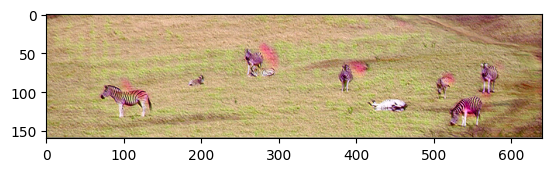

In [14]:
# from ultralytics.yolo.utils import DEFAULT_CFG, ROOT, ops
import torch.nn.functional as F

n_iter = 500     # số lần attack trên 1 ảnh

data_info = cfg2dict(data_info_path)
cfg = get_cfg(yaml_path)
#data loader
loader = build_dataloader(cfg= cfg, batch=1, img_path=img_path,data_info=data_info)

output_path = "./results"

for i, batch in enumerate(loader[0]):
    path_img        = loader[1].im_files[i]
    name_img        = os.path.split(path_img)[-1]

    print(f"[{i}/{len(loader[0])}] Attacking image {name_img} ...")

    batch_tensor    = torch.Tensor(batch['img'].float()).cuda()
    origin_tensor   = torch.Tensor(batch['img'].float()).cuda()
    img_before      = cv2.imread(path_img)
    x,y,_           = img_before.shape              # original img shape
    x_new,y_new     = batch_tensor.shape[-2:]       # shape img after augment with yolov8

    x1,y1,x2,y2     = cut_images((x,y,3),[x_new,y_new])
    
    # Acquire targets and corresponding labels to attack
    # target_boxes, target_labels, adv_labels = get_targets(img_before, detector)
    # print(adv_labels)

    # batch['cls'] = adv_labels
    # batch['bboxes'] = batch['bboxes'][:adv_labels.size()[0]]
    # batch['batch_idx'] = batch['batch_idx'][:adv_labels.size()[0]]

    batch_tensor.requires_grad_()
    batch_tensor.retain_grad()
    for j in tqdm(range(n_iter)):
        optimizer.zero_grad()
        perturbation = generator(batch_tensor)
        adv_inputs = torch.add(batch_tensor, perturbation)
        adv_inputs = torch.clamp(adv_inputs, 0, 255)
        
        b = trainer.model(adv_inputs / 255.)

        # Trả về Tensor gồm [8, 86]: 8 object detect được bên trong ảnh, mỗi object sẽ có: x, y, x, y, conf, cls, 80 conf score
        preds = non_max_suppression(b,
                                    cfg.conf,
                                    cfg.iou,
                                    agnostic=cfg.agnostic_nms,
                                    max_det=cfg.max_det,
                                    classes=cfg.classes)
        # print("preds:", preds[0], preds[0].size())
        pred_conf = preds[0][:, 6:]
        pred_cls = preds[0][:, 5].type(torch.LongTensor).to(device)
        adv_cls = torch.ones_like(pred_cls) * 14
        # print("pred_cls:", pred_cls)
        # print("adv_cls:", adv_cls)
        real_loss = F.cross_entropy(pred_conf, pred_cls, reduction="sum")
        adv_loss = F.cross_entropy(pred_conf, adv_cls, reduction="sum")
        
        loss_misclassify = 5 * (adv_loss)
        # adv_loss.backward(retain_graph = True)
    
        loss_pertub = 0.05 * L2_dist(batch_tensor, adv_inputs)
        total_loss = loss_misclassify
        total_loss.backward(retain_graph = True)

        optimizer.step()

        # total_losses.append(total_loss.data.cpu())
        
        # if (j + 1) % 101 == 0:
        print(f"[INFO] Loss misclassify: {loss_misclassify.data} | Loss pertub: {loss_pertub.data} | Total loss: {total_loss.data}")

        # print(loss_misclassify)


    plt.imshow(adv_inputs.squeeze().detach().cpu().permute(1, 2, 0)/255)

    break

In [ ]:
n_iter = 1000     # số lần attack trên 1 ảnh

data_info = cfg2dict(data_info_path)
cfg = get_cfg(yaml_path)
#data loader
loader = build_dataloader(cfg= cfg, batch=1, img_path=img_path,data_info=data_info)

output_path = "./results"

for i, batch in enumerate(loader[0]):
    path_img        = loader[1].im_files[i]
    name_img        = os.path.split(path_img)[-1]

    print(f"[{i}/{len(loader[0])}] Attacking image {name_img} ...")

    batch_tensor    = torch.Tensor(batch['img'].float() / 255.0).cuda()
    img_before      = cv2.imread(path_img)
    x,y,_           = img_before.shape              # original img shape
    x_new,y_new     = batch_tensor.shape[-2:]       # shape img after augment with yolov8

    x1,y1,x2,y2     = cut_images((x,y,3),[x_new,y_new])
    
    # Acquire targets and corresponding labels to attack + Assign adversarial label
    target_boxes, target_labels, adv_labels = get_targets(img_before, detector)

    # Assign adversarial label
    # adv_labels = get_adv_labels(target_labels)

    # # Change class and bboxes gt
    # batch['cls'] = adv_labels
    # batch['bboxes'] = batch['bboxes'][:adv_labels.size()[0]]
    # batch['batch_idx'] = batch['batch_idx'][:adv_labels.size()[0]]

    batch_tensor.requires_grad_()
    batch_tensor.retain_grad()
    
    total_losses = []
    for j in tqdm(range(n_iter)):
        perturbation = generator(batch_tensor)
        adv_inputs = batch_tensor + perturbation
        adv_inputs = torch.clamp(adv_inputs, 0, 1)
        # print("Before detect grad:", adv_inputs.grad)
        # plt.imshow(adv_inputs.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0) / 255)

        # new_img = adv_inputs.squeeze(0).detach().cpu()
        # new_boxes, new_target = get_targets(new_img, detector)
        # print("new_boxes:", new_boxes)
        # print("new_target", new_target)
        # print("adv_labels:", adv_labels)
        adv_inputs.retain_grad()
        
        b = trainer.model(adv_inputs)

        loss_misclassify, _ = trainer.criterion(b, batch)
        break
        # print("loss_misclassify:", loss_misclassify)
        loss_pertub = criterion(batch_tensor, adv_inputs)
        # print("loss_pertub", loss_pertub)
        
        total_loss = 10 * loss_misclassify + loss_pertub
        total_loss.retain_grad()
        total_loss.backward()

        optimizer.step()

        total_losses.append(total_loss.data.cpu())
        
        if (j + 1) % 101 == 0:
            print(f"[INFO] Loss misclassify: {loss_misclassify.data} | Loss pertub: {loss_pertub.data} | Total loss: {total_loss.data}")
    
    # print(total_losses, len(total_losses))
    break
    # Save loss each batch
    img_loss_path = os.path.join(output_path, "loss_img")
    if not os.path.exists(img_loss_path):
        os.makedirs(img_loss_path)
    plt.figure()
    plt.plot(total_losses)
    plt.savefig(f'{img_loss_path}/{name_img}')

    
        
# # Save weight
# model_path = os.path.join(output_path, 'models')
# if not os.path.exists(model_path):
#     os.makedirs(model_path)
# torch.save(generator.state_dict(), f"{model_path}/Unet_1_epoch.pt")
    

train: Scanning /home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/labels/val.cache... 4952 images, 48 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


[0/5000] Attacking image 000000298251.jpg ...
====================VAO DAY====================


self.model: <class 'ultralytics.nn.tasks.DetectionModel'>
Original shape: torch.Size([1, 3, 640, 640])
Layer: Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
torch.Size([1, 16, 320, 320])
Layer: Conv(
  (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (act): SiLU(inplace=True)
)
torch.Size([1, 32, 160, 160])
Layer: C2f(
  (cv1): Conv(
    (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (cv2): Conv(
    (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
    (act): SiLU(inplace=True)
  )
  (m): ModuleList(
    (0): Bottleneck(
      (cv1): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
    )
  )
)
torch.Size([1, 32, 160, 160]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

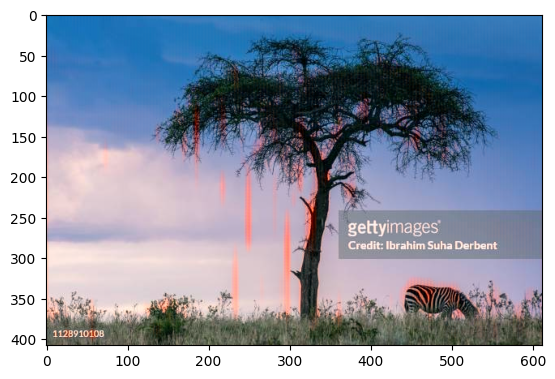

In [5]:
generator = Unet (
                in_chans = 3,  #Number of channels in the input to the U-Net model
                out_chans = 3, #Number of channels in the output to the U-Net model
                chans = 64,    #Number of output channels of the first convolution layer
            ).cuda()
generator.load_state_dict(torch.load("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/generator.pt"))
generator.eval()

img = "/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/gettyimages-1128910108-612x612.jpg"
img = torch.Tensor(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB).transpose(2, 0, 1)).unsqueeze(0).to(device)

# img.size()

pertub = generator(img)
adv_img = torch.clamp(img + pertub, 0, 255)
adv_img = adv_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0) / 255
plt.imshow(adv_img)
# img.size()

In [6]:
pertub

tensor([[[[ 0.6875,  0.5877, -2.1668,  ..., -0.9574, -0.3214, -1.4725],
          [ 3.0965,  2.7092, -2.9058,  ..., -0.1705,  1.3033, -1.9266],
          [ 4.7331,  4.4763, -3.1212,  ...,  1.3573,  3.9554, -1.8740],
          ...,
          [-3.0341, -4.8650, -8.0614,  ..., -5.5103, -3.5660, -3.0197],
          [-3.3382, -5.0014, -7.4654,  ..., -5.5911, -3.7284, -2.9816],
          [-2.7882, -4.0097, -5.4307,  ..., -4.4580, -3.0150, -2.4314]],

         [[ 0.6523,  0.7699,  0.0352,  ...,  0.5135,  0.7936,  0.1536],
          [ 0.7241,  0.7262, -0.5510,  ...,  0.3189,  0.7038, -0.4911],
          [ 0.7014,  0.6248, -0.9828,  ...,  0.2106,  0.3922, -1.0664],
          ...,
          [ 2.3598,  3.9282,  4.0507,  ...,  4.0595,  3.3414,  1.8344],
          [ 2.3167,  3.7898,  3.9731,  ...,  3.8792,  3.1972,  1.7792],
          [ 1.6215,  2.6722,  2.8090,  ...,  2.7470,  2.3320,  1.3355]],

         [[-0.3296, -0.2761, -0.3038,  ...,  0.3142,  0.4950,  0.5415],
          [-2.4199, -2.8121, -

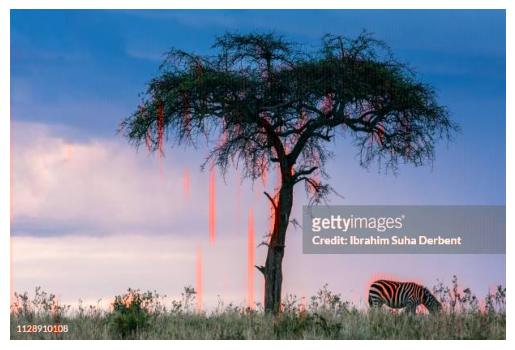

In [7]:
plt.imshow(adv_img)
plt.axis("off")
plt.savefig('gettyimages.png',bbox_inches='tight', transparent="True", pad_inches=0)

====================VAO DAY====================
############### self.predictor chua duoc khoi tao ###############
################################## HERE nn_module ##################################
<class 'ultralytics.nn.tasks.DetectionModel'>
####################################################################################
Detector postprocess: preds [tensor([[458.5656, 358.5220, 560.4354, 408.3544,   0.7310,  22.0000]], device='cuda:0')]


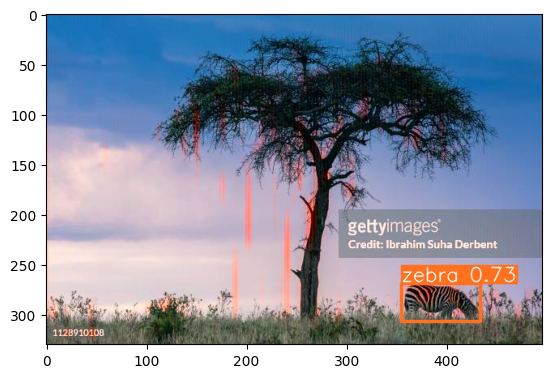

In [12]:
img_new_p = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/gettyimages.png'
adv = cv2.imread(img_new_p)

new_detec = YOLO("yolov8n.pt")
new_detec.conf = 0.25
result = new_detec(adv)[0]
det_img_1 = cv2.cvtColor(result.plot(labels=True), cv2.COLOR_BGR2RGB)
plt.imshow(det_img_1)

In [20]:
img_new_p = '/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/out3.png'
adv = cv2.imread(img_new_p)

new_detec = YOLO("yolov8n.pt")
new_detec.conf = 0.1
result = new_detec(adv)[0]
det_img_1 = cv2.cvtColor(result.plot(labels=True), cv2.COLOR_BGR2RGB)
plt.imshow(det_img_1)

====================VAO DAY====================
############### self.predictor chua duoc khoi tao ###############
################################## HERE nn_module ##################################
<class 'ultralytics.nn.tasks.DetectionModel'>
####################################################################################
Detector postprocess: preds [tensor([[5.1966e+02, 1.0357e+02, 5.7321e+02, 1.4661e+02, 4.8339e-01, 2.2000e+01],
        [6.9256e+01, 9.1400e+01, 1.4026e+02, 1.3547e+02, 3.7410e-01, 2.2000e+01],
        [3.7713e+02, 6.4957e+01, 3.9150e+02, 1.0108e+02, 2.8948e-01, 0.0000e+00],
        [2.5476e+02, 4.2978e+01, 2.7230e+02, 8.1783e+01, 2.6288e-01, 0.0000e+00],
        [2.5600e+02, 4.3308e+01, 2.7952e+02, 8.2463e+01, 2.2754e-01, 0.0000e+00],
        [2.5558e+02, 4.2782e+01, 2.6743e+02, 8.0472e+01, 2.2586e-01, 0.0000e+00],
        [2.6233e+02, 4.5608e+01, 2.7959e+02, 8.2553e+01, 1.8693e-01, 0.0000e+00],
        [5.6085e+02, 6.1892e+01, 5.8234e+02, 1.0316e+02, 1.3339e-01

KeyError: 104

In [ ]:
result.boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[124.6020, 197.3463, 171.0578, 251.4985,   0.8657,  18.0000],
        [109.6398, 171.4854, 132.4796, 211.0817,   0.8586,  18.0000],
        [ 65.9059, 165.3207, 106.5891, 199.8819,   0.7826,  18.0000],
        [ 12.9183, 187.0616,  48.6754, 231.5601,   0.7485,  18.0000],
        [181.9740, 163.0430, 218.8813, 187.2368,   0.7179,  18.0000],
        [287.5474, 201.4408, 356.5301, 257.3753,   0.7075,  18.0000],
        [ 35.0526, 169.6627,  69.2892, 194.0516,   0.6749,  18.0000],
        [214.7910, 159.9942, 239.8452, 181.4033,   0.6655,  18.0000],
        [ 12.8587, 174.9157,  35.6726, 191.1633,   0.4172,  18.0000]], device='cuda:0')
cls: tensor([18., 18., 18., 18., 18., 18., 18., 18., 18.], device='cuda:0')
conf: tensor([0.8657, 0.8586, 0.7826, 0.7485, 0.7179, 0.7075, 0.6749, 0.6655, 0.4172], device='cuda:0')
data: tensor([[124.6020, 197.3463, 171.0578, 251.4985,   0.8657,  18.0000],
        [109.6398, 171.485

In [ ]:
result.boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


ultralytics.yolo.engine.results.Boxes object with attributes:

boxes: tensor([[1.2494e+02, 1.9724e+02, 1.7089e+02, 2.5162e+02, 8.5785e-01, 1.8000e+01],
        [1.0978e+02, 1.7137e+02, 1.3242e+02, 2.1125e+02, 8.4824e-01, 1.8000e+01],
        [1.3100e+01, 1.8696e+02, 4.8502e+01, 2.3160e+02, 8.1630e-01, 1.8000e+01],
        [6.5889e+01, 1.6540e+02, 1.0651e+02, 1.9972e+02, 7.9735e-01, 1.8000e+01],
        [2.8801e+02, 2.0106e+02, 3.5640e+02, 2.5772e+02, 7.5501e-01, 1.8000e+01],
        [1.8202e+02, 1.6302e+02, 2.1897e+02, 1.8742e+02, 6.9784e-01, 1.8000e+01],
        [3.4906e+01, 1.6974e+02, 6.9228e+01, 1.9428e+02, 6.7600e-01, 1.8000e+01],
        [2.1453e+02, 1.5974e+02, 2.3984e+02, 1.8145e+02, 5.7275e-01, 1.8000e+01],
        [1.2795e+01, 1.7460e+02, 3.5535e+01, 1.9207e+02, 3.4751e-01, 1.8000e+01]], device='cuda:0')
cls: tensor([18., 18., 18., 18., 18., 18., 18., 18., 18.], device='cuda:0')
conf: tensor([0.8579, 0.8482, 0.8163, 0.7973, 0.7550, 0.6978, 0.6760, 0.5727, 0.3475], device='cud

In [45]:
batch = next(iter(loader[0]))
batch

{'im_file': ['/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/datasets/datasets/coco2017/images/val/000000298251.jpg'],
 'ori_shape': [[159, 640]],
 'resized_shape': [array([160, 640])],
 'ratio_pad': [[[1.0, 1.0], [0.0, 0.5]]],
 'img': tensor([[[[ 84,  96,  93,  ..., 165, 167, 180],
           [ 98, 117, 103,  ..., 187, 180, 184],
           [ 94, 125, 129,  ..., 197, 188, 193],
           ...,
           [173, 174, 173,  ...,  57, 107, 114],
           [182, 157, 164,  ...,  67, 112,  80],
           [114, 114, 114,  ..., 114, 114, 114]],
 
          [[ 68,  76,  70,  ..., 137, 135, 145],
           [ 67,  82,  66,  ..., 166, 157, 157],
           [ 70,  97,  97,  ..., 181, 172, 173],
           ...,
           [152, 158, 162,  ...,  39,  84,  90],
           [162, 142, 155,  ...,  51,  94,  60],
           [114, 114, 114,  ..., 114, 114, 114]],
 
          [[ 32,  43,  38,  ...,  98,  97, 107],
           [ 46,  62,  47,  ..., 123, 113, 112],
           [ 46,  75,  76,  ..., 132, 1

In [29]:
batch_tensor    = torch.Tensor(batch['img'].float()).cuda()

b = trainer.model(batch_tensor)

torch.Size([1, 64, 20, 80]) torch.Size([1, 128, 10, 40]) torch.Size([1, 256, 5, 20])
######################################### DETECTOR VAO DAY #########################################
self.dfl(box): tensor([[[0.5363, 0.8264, 0.9953,  ..., 0.9260, 1.9892, 3.5618],
         [0.3324, 0.4145, 0.3866,  ..., 0.9756, 1.7000, 2.6860],
         [0.4763, 0.8363, 0.9811,  ..., 1.4482, 0.4704, 0.5344],
         [0.0321, 0.0760, 0.0679,  ..., 0.3549, 0.3043, 0.3402]]], device='cuda:0', grad_fn=<ViewBackward0>) torch.Size([1, 4, 2100])
torch.Size([1, 84, 2100])
False


In [30]:
# detector.model.cuda()
detector.model(batch_tensor)

torch.Size([1, 64, 20, 80]) torch.Size([1, 128, 10, 40]) torch.Size([1, 256, 5, 20])
######################################### DETECTOR VAO DAY #########################################
self.dfl(box): tensor([[[0.5363, 0.8264, 0.9953,  ..., 0.9260, 1.9892, 3.5618],
         [0.3324, 0.4145, 0.3866,  ..., 0.9756, 1.7000, 2.6860],
         [0.4763, 0.8363, 0.9811,  ..., 1.4482, 0.4704, 0.5344],
         [0.0321, 0.0760, 0.0679,  ..., 0.3549, 0.3043, 0.3402]]], device='cuda:0') torch.Size([1, 4, 2100])
torch.Size([1, 84, 2100])
False


(tensor([[[3.7598e+00, 1.2040e+01, 1.9943e+01,  ..., 5.6835e+02, 5.6770e+02, 5.7556e+02],
          [2.7987e+00, 2.6461e+00, 2.7252e+00,  ..., 1.3407e+02, 1.2167e+02, 1.0647e+02],
          [8.1006e+00, 1.3302e+01, 1.5811e+01,  ..., 7.5976e+01, 7.8707e+01, 1.3108e+02],
          ...,
          [4.8978e-06, 9.6421e-07, 1.7046e-05,  ..., 1.6595e-06, 1.7457e-06, 5.3998e-06],
          [2.3807e-08, 2.7315e-07, 3.7633e-07,  ..., 4.6272e-07, 2.6644e-07, 1.3734e-06],
          [1.1871e-06, 2.7445e-06, 1.2938e-05,  ..., 1.7857e-07, 1.1254e-07, 6.9153e-07]]], device='cuda:0'),
 [tensor([[[[ 7.1179e+01,  3.6366e+01,  3.0566e+01,  ...,  4.0304e+01,  4.3140e+01,  1.6014e+01],
            [ 3.8157e+01,  1.6734e+01, -8.5658e-01,  ...,  5.3544e+00,  6.2488e+00, -4.2023e+00],
            [ 2.7325e+01,  6.9801e+00, -1.4499e-01,  ..., -7.8266e-01, -1.3256e+01, -1.4173e+01],
            ...,
            [ 6.2556e+01,  2.2462e+01,  3.2541e+00,  ...,  5.8582e-01,  1.0312e+01,  5.5650e+00],
            [ 2.

In [24]:
detector = YOLO("yolov8n.pt")
detector.model.cuda()
detector.model.eval()
detector.conf = 0.25

detector2 = YOLO("yolov8n.pt")
detector2.model.cuda()
detector2.model.eval()
detector2.conf = 0.25

trainer = DetectionTrainer(yaml_path)
trainer.setup_model()
trainer.set_model_attributes()
trainer.model.eval()
trainer.model.cuda()

trainer2 = DetectionTrainer(yaml_path)
trainer2.setup_model()
trainer2.set_model_attributes()
trainer2.model.eval()
trainer2.model.cuda()

compare_models(trainer.model, detector.model)

Ultralytics YOLOv8.0.83 🚀 Python-3.10.13 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3902MiB)
yolo/engine/trainer: task=detect, mode=predict, model=yolov8n.pt, data=ultralytics/datasets/coco2017.yaml, epochs=1, patience=10, batch=1, imgsz=640, save=True, save_period=100, cache=False, device=0, workers=8, project=None, name=None, augment=False, exist_ok=False, pretrained=False, optimizer=SGD, verbose=False, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, min_memory=False, overlap_mask=True, mask_ratio=4, dropout=0.0, YOLO_VERBOSE=False, val=True, split=val, save_json=False, save_hybrid=False, conf=0.25, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=True, save_conf=False, save_crop=False, hide_labels=True, hide_conf=True, vid_stride=1, line_thickness=3, visualize=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

torch.Size([1, 64, 32, 32]) torch.Size([1, 128, 16, 16]) torch.Size([1, 256, 8, 8])
######################################################### Son added #########################################################
self.dfl(box): tensor([[[7.6369, 7.6369, 7.6369,  ..., 7.3844, 7.3844, 7.3844],
         [7.5254, 7.5254, 7.5254,  ..., 7.5797, 7.5797, 7.5797],
         [7.4407, 7.4407, 7.4407,  ..., 7.3731, 7.3731, 7.3731],
         [7.5138, 7.5138, 7.5138,  ..., 7.4954, 7.4954, 7.4954]]], grad_fn=<ViewBackward0>) torch.Size([1, 4, 1344])
modules.py | dbox in Trainer: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>) torch.Size([1, 4, 1344])
torch.Size([1, 84, 1344])
torch.Size([1, 64, 4, 4]) torch.Size([1, 128, 2, 2]) torch.Size([1, 256, 1, 1])
######################################### DETECTOR VAO DAY #########################################
self.dfl(bo


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.Conv                  [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.Conv                  [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.C2f                   [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.Conv                  [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.C2f                   [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.Conv                  [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.C2f                   [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.Conv                  [128

torch.Size([1, 64, 32, 32]) torch.Size([1, 128, 16, 16]) torch.Size([1, 256, 8, 8])
######################################################### Son added #########################################################
self.dfl(box): tensor([[[7.6369, 7.6369, 7.6369,  ..., 7.3844, 7.3844, 7.3844],
         [7.5254, 7.5254, 7.5254,  ..., 7.5797, 7.5797, 7.5797],
         [7.4407, 7.4407, 7.4407,  ..., 7.3731, 7.3731, 7.3731],
         [7.5138, 7.5138, 7.5138,  ..., 7.4954, 7.4954, 7.4954]]], grad_fn=<ViewBackward0>) torch.Size([1, 4, 1344])
modules.py | dbox in Trainer: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], grad_fn=<MulBackward0>) torch.Size([1, 4, 1344])
torch.Size([1, 84, 1344])
torch.Size([1, 64, 4, 4]) torch.Size([1, 128, 2, 2]) torch.Size([1, 256, 1, 1])
######################################### DETECTOR VAO DAY #########################################
self.dfl(bo

In [31]:
compare_models(trainer.model, detector.model)

Models match perfectly! :)


In [32]:
compare_models(trainer.model, detector2.model)

Models match perfectly! :)


In [33]:
compare_models(trainer2.model, detector.model)

Models match perfectly! :)


In [34]:
compare_models(trainer2.model, detector2.model)

Models match perfectly! :)


In [84]:
x0 = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x0.txt")
x1 = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x1.txt")
x2 = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x2.txt")
x0.shape, x1.shape, x2.shape

((144, 1600), (144, 400), (144, 100))

In [85]:
x0_trainer = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x0_trainer.txt")
x1_trainer = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x1_trainer.txt")
x2_trainer = np.loadtxt("/home/son/Desktop/Research/YOLO_ATTACK_GRAD/unet/after_detect_x2_trainer.txt")
x0_trainer.shape, x1_trainer.shape, x2_trainer.shape

((144, 1600), (144, 400), (144, 100))

In [86]:
(abs(x0 - x0_trainer) > 1).sum()

0


0: 480x640 1 car, 5 boats, 6 birds, 60.9ms
Speed: 2.2ms preprocess, 60.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


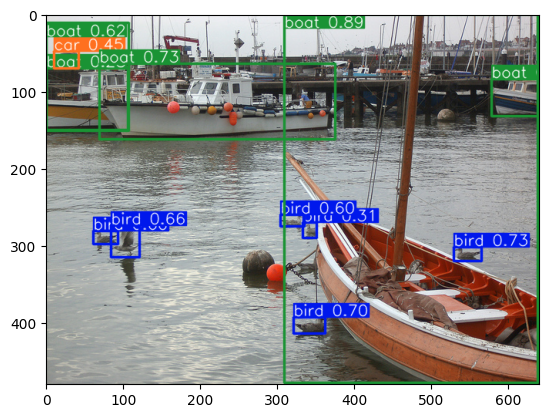

In [ ]:
img = cv2.imread(test_loader[2][0])
result = detector(img)[0]
det_img_0 = cv2.cvtColor(result.plot(labels=True, line_width=2), cv2.COLOR_BGR2RGB)
plt.imshow(det_img_0)

In [ ]:
result.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 8.,  8., 14.,  8., 14., 14.,  8., 14., 14.,  2., 14.,  8.], device='cuda:0')
conf: tensor([0.8916, 0.8218, 0.7328, 0.7256, 0.6971, 0.6580, 0.6189, 0.6050, 0.5985, 0.4524, 0.3091, 0.2804], device='cuda:0')
data: tensor([[3.0928e+02, 4.2334e-01, 6.3898e+02, 4.7872e+02, 8.9159e-01, 8.0000e+00],
        [5.7813e+02, 8.4726e+01, 6.3969e+02, 1.3205e+02, 8.2177e-01, 8.0000e+00],
        [5.2968e+02, 3.0254e+02, 5.6540e+02, 3.2060e+02, 7.3279e-01, 1.4000e+01],
        [6.9869e+01, 6.4412e+01, 3.7508e+02, 1.6206e+02, 7.2561e-01, 8.0000e+00],
        [3.2104e+02, 3.9390e+02, 3.6231e+02, 4.1413e+02, 6.9711e-01, 1.4000e+01],
        [8.4997e+01, 2.7417e+02, 1.2115e+02, 3.1600e+02, 6.5797e-01, 1.4000e+01],
        [2.9705e-01, 1.1747e+01, 1.0747e+02, 1.5115e+02, 6.1894e-01, 8.0000e+00],
        [6.1220e+01, 2.8157e+02, 9.3163e+01, 2.9873e+02, 6.0496e-01, 1.4000e+01],
        [3.0402e+02, 2.6090e+02, 3.3514e+02, 2.7504e+02, 5.98

In [ ]:
def get_target(detector, img_path):
    img = cv2.imread(img_path)
    results = detector(img_path[0]).boxes
    
    return results.xyxy, results.cls